**Заголовок:** Разрабокта линейных моделей МО скоринга коров

**Описание проекта:** Фермер хочет купить бурёнок, чтобы расширить поголовье стада коров. Он хочет, чтобы каждая корова давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям.
Необходимо разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. У нас есть подробные данные о коровах, которых можно купить.

**Цель исследования:** Отобрать коров, которые будут давать не менее 6000 кг вкусного молока в год.

**Имеющиеся данные:**

1. Файл **ferma_main.csv** содержит данные о стаде фермера на текущий момент.

    Описание данных:
    * `id` — уникальный идентификатор коровы.
    * `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
    * `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
    * `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
    * `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
    * `Порода` — порода коровы.
    * `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    * `порода папы_быка` — порода папы коровы.
    * `Жирность,%` — содержание жиров в молоке (в процентах).
    * `Белок,%` — содержание белков в молоке (в процентах).
    * `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
    * `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

2. Файл **ferma_dad.csv** хранит имя папы каждой коровы в стаде фермера.

    Описание данных:
    * `id` — уникальный идентификатор коровы.
    * `Имя Папы` — имя папы коровы.

3. Файл **cow_buy.csv** — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

    Описание данных:
    * `Порода` — порода коровы.
    * `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    * `порода папы_быка` — порода папы коровы.
    * `Имя_папы` — имя папы коровы.
    * `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
    * `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
    * `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**Ход исследования:**
* Загрузка и предобработка данных
* Исследовательский анализ данных
* Корреляционный анализ
* Создание модели линейной регрессии для прогнозирования удоя
* Создание модели логистической регрессии для прогнозирования вкуса молока
* Прогноз удоя и вкуса молока коров, доуступных для покупки

**Общий вывод**

Получена функция, позволяющая получать список коров для покупки с возможностью задавать как вероятность получения годового удоя, превышающего 6000 кг, так и значение метрики precision в предсказании вкуса молока.


<a class="ancor" id="0-bullet"></a>
## Оглавление

* [1. Загрузка данных](#1-bullet)
  * [Первичное изучение данных](#2-bullet)
  * [Стандартизация названий признаков](#3-bullet)
  * [Выводы](#4-bullet)
* [2. Предобработка данных](#5-bullet)
  * [Работа с пропусками](#6-bullet)
  * [Поиск дубликатов](#7-bullet)
  * [Поиск аномальных значений](#8-bullet)
  * [Выводы](#9-bullet)
* [3. Исследовательский анализ данных](#10-bullet)
  * [Статистический анализ признаков](#11-bullet)
  * [Построение графиков признаков](#12-bullet)
  * [Выводы](#13-bullet)
* [4. Статистический анализ данных](#14-bullet)
  * [Изучение взаимосвязи между признаками](#15-bullet)
  * [Построение диаграмм рассеяния удоя](#16-bullet)
  * [Тесты статистических гипотез](#17-bullet)
  * [Выводы](#18-bullet)
* [5. Обучение моделей линейной регрессии](#19-bullet)
  * [Базовая модель](#20-bullet)
  * [Модель со статистически значимыми признаками](#21-bullet)
  * [Модель с линеаризированными признаками](#22-bullet)
  * [Модель с информацией об отцах коров](#23-bullet)
  * [Сравнение моделей](#24-bullet)
  * [Прогноз удоя коров, доступных для покупки](#25-bullet)
  * [Выводы](#26-bullet)
* [6. Обучение модели логистической регрессии](#26-bullet)
  * [Базовая модель](#27-bullet)
  * [Продвинутая модель](#28-bullet)
  * [Сравнение моделей](#29-bullet)
  * [Предсказание вкусного молока](#30-bullet)
  * [Выводы](#31-bullet)
* [7. Итоговое предсказание](#32-bullet)
* [Итоговые выводы](#33-bullet)


In [1]:
import math
from typing import cast, Sequence, Optional, Callable, Literal, Union
from dataclasses import dataclass, field
from itertools import combinations
from functools import partial

from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_percentage_error,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)


<a class="ancor" id="1-bullet"></a>
## 1. Загрузка данных

In [2]:
try:
    df_main = pd.read_csv("/datasets/ferma_main.csv", sep=';', decimal=',')
    df_dads = pd.read_csv("/datasets/ferma_dad.csv", sep=';', decimal=',')
    df_buy  = pd.read_csv("/datasets/cow_buy.csv", sep=';', decimal=',')
except FileNotFoundError:
    df_main = pd.read_csv("../data/2_1_linear_models_ferma_main.csv", sep=';', decimal=',')
    df_dads = pd.read_csv("../data/2_1_linear_models_ferma_dad.csv", sep=';', decimal=',')
    df_buy  = pd.read_csv("../data/2_1_linear_models_cow_buy.csv", sep=';', decimal=',')

Данные загружены в 3 датафрейма:
* `df_main` - Основная инфомрация о коровах, уже имеющихся на ферме
* `df_dads` - Информация об отцах коров, имеющихся на ферме
* `df_buy` - Информация о коровах, которых можно приобрести

<a class="ancor" id="2-bullet"></a>
### Первичное изучение данных.

Создадим функцию для вывода первичной информации о датафреймах

In [3]:
def show_df(df: pd.DataFrame, n: int = 5) -> None:
    """
    Выводит основную информацию о датафрейме.

    Параметры:
    ----------
    - df: DataFrame с данными.
    - n: Количество строк для отображения.
    """

    print(f"Первые {n} строк:")
    display(df.head(n))
    try:
        temp = df.describe(include=[np.number])
        print("Статистика по числовым столбцам:")
        display(temp)
    except ValueError:
        print("Нет числовых столбцов для отображения.")
    try:
        temp = df.describe(include=[object])
        print("Статистика по категориальным столбцам:")
        display(temp)
    except ValueError:
        print("Нет категориальных столбцов для отображения.")
    print("Информация о датафрейме:")
    df.info()

Посмотрим на основные данные о уже имеющихся коровах.

In [4]:
show_df(df_main, 10)

Первые 10 строк:


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинные,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


Статистика по числовым столбцам:


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,14.542744,1922.682965,0.912855,3.603943,3.075666
std,183.096982,1638.401021,1.301301,182.392548,0.032209,0.168020,0.002540
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,159.250000,5751.750000,13.500000,1772.250000,0.890000,3.590000,3.074000
50%,317.500000,6130.500000,14.700000,1880.500000,0.930000,3.650000,3.076000
75%,475.750000,6501.000000,15.600000,2058.750000,0.940000,3.720000,3.077000
max,629.000000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Статистика по категориальным столбцам:


,Порода,Тип пастбища,порода папы_быка,Вкус молока,Возраст
count,634,634,634,634,634
unique,2,3,3,2,2
top,Вис Бик Айдиал,Холмистое,Соверин,вкусно,более_2_лет
freq,373,356,316,371,524


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-nu

Основные данные загрузились корректно.

Значения удоя выглядят подозрительно, поработаем с этим позже.

Посмотрим на датафрейм с инфомрацией об отцах коров

In [5]:
show_df(df_dads, 10)

Первые 10 строк:


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


Статистика по числовым столбцам:


,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


Статистика по категориальным столбцам:


,Имя Папы
count,629
unique,4
top,Барин
freq,240


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Данные об отцах коров на ферме загрузились корректно, на первый взгляд особых проблем в данных не видно.

Посмотрим информацию о датафрейме с коровами, доступными для покупки.

In [6]:
show_df(df_buy, 10)

Первые 10 строк:


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


Статистика по числовым столбцам:


,"Текущая_жирность,%","Текущий_уровень_белок,%"
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


Статистика по категориальным столбцам:


,Порода,Тип пастбища,порода папы_быка,Имя_папы,Возраст
count,20,20,20,20,20
unique,2,2,2,4,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,более_2_лет
freq,11,11,12,8,15


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Данные о коровах, которых можно купить загрузились корректно. Проблем с данными не видно.

<a class="ancor" id="3-bullet"></a>
### Стандартизация названий признаков
Все столбцы имеют не очень удобные для дальнейшей работы названия.

Заменим их на более удобные.

In [7]:
main_cols = {
    "id": "Идентификатор",
    "milk_yield": "Удой, кг",
    "meal_value": "ЭКЕ (Энергетическая кормовая единица)",
    "meal_protein": "Протеин в корме, г",
    "spo": "СПО (Сахаро-протеиновое соотношение)",
    "breed": "Порода",
    "pasture": "Тип пастбища",
    "dad_breed": "Порода папы коровы",
    "milk_fat": "Жирность молока, %",
    "milk_protein": "Белок молока, %",
    "milk_taste": "Вкус молока",
    "age": "Возраст",
}
df_main.columns = list(main_cols.keys())

In [8]:
dad_cols = {"id": "Идентификатор", "dad_name": "Имя папы коровы"}
df_dads.columns = list(dad_cols.keys())

In [9]:
buy_cols = {
    "breed": "Порода",
    "pasture": "Тип пастбища",
    "dad_breed": "Порода папы коровы",
    "dad_name": "Имя папы коровы",
    "milk_fat": "Жирность молока, %",
    "milk_protein": "Белок молока, %",
    "age": "Возраст",
}
df_buy.columns = list(buy_cols.keys())

Создадим словать для отображения названий признаков обратно в привычный формат.

In [10]:
translator = {**main_cols, **dad_cols, **buy_cols}

Создадим пару функций для удобства получения нужных столбцов по категориям.

In [11]:
def get_num_cols(df: pd.DataFrame, exclude_cols: list[str] = ["id"]) -> list[str]:
    """
    Возвращает список числовых столбцов в датафрейме, исключая указанные колонки.

    Параметры
    ----------
    - df: Датафрейм с данными
    - exclude_cols: Список колонок, которые нужно исключить из результата
    """
    return list(df.drop(exclude_cols, axis=1).select_dtypes(np.number).columns)


def get_cat_cols(df: pd.DataFrame, exclude_cols: list[str] = []) -> list[str]:
    """
    Возвращает список категориальных столбцов в датафрейме, исключая указанные колонки.

    Параметры
    ----------
    - df: Датафрейм с данными
    - exclude_cols: Список колонок, которые нужно исключить из результата
    """
    return list(df.drop(exclude_cols, axis=1).select_dtypes(object).columns)

<a class="ancor" id="4-bullet"></a>
### Выводы

Все данные загружены в 3 датафрейма:
* `df_main` - Основная инфомрация о коровах, уже имеющихся на ферме
* `df_dads` - Информация об отцах коров, имеющихся на ферме
* `df_buy` - Информация о коровах, которых можно приобрести

Названия колонок данных приведены к каноничному виду и создан словарь для отображения этих названий в понятные русскоязычные аналоги.

Возможно имеются некоторые проблемы с данными (как минимум, с удоем).

[Оглавление](#0-bullet)

<a class="ancor" id="5-bullet"></a>
##  2. Предобработка данных

<a class="ancor" id="6-bullet"></a>
### Работа с пропусками

На этапе загрузки данных явных пропусков в данных не обнаружено.

<a class="ancor" id="7-bullet"></a>
### Поиск дубликатов

Проверим на наличие явных дубликатов

In [12]:
print("Количество дубликатов в df_main:", df_main.duplicated().sum())
print("Количество дубликатов в df_dads:", df_dads.duplicated().sum())
print("Количество дубликатов в df_buy:", df_buy.duplicated().sum())

Количество дубликатов в df_main: 5
Количество дубликатов в df_dads: 0
Количество дубликатов в df_buy: 4


Удалим явные дубликаты

In [13]:
df_main.drop_duplicates(inplace=True, ignore_index=True)
df_buy.drop_duplicates(inplace=True, ignore_index=True)

Поищем неявные дубликаты. Начнём с коров на ферме.

In [ ]:
for col in ["breed", "pasture", "dad_breed", "age", "milk_taste"]:
    print(f"Уникальные значения в столбце '{translator[col]}':")
    print(df_main[col].unique(), end="\n\n")

Уникальные значения в столбце 'Порода':
['Вис Бик Айдиал' 'РефлешнСоверинг']

Уникальные значения в столбце 'Тип пастбища':
['Равнинное' 'Равнинные' 'Холмистое']

Уникальные значения в столбце 'Порода папы коровы':
['Айдиал' 'Соверин' 'Айдиалл']

Уникальные значения в столбце 'Возраст':
['более_2_лет' 'менее_2_лет']

Уникальные значения в столбце 'Вкус молока':
['вкусно' 'не вкусно']



Видны неявные дубликаты в столбцах породы отца и типа пастбища, скорректируем их.

In [15]:
df_main["pasture"] = df_main["pasture"].str.replace("Равнинные", "Равнинное")
df_main["dad_breed"] = df_main["dad_breed"].str.replace("Айдиалл", "Айдиал")

Эта операция могла привести к появлению явных дубликатов, проверим это.

In [16]:
df_main.duplicated().sum()

np.int64(0)

Проверим наличие неявных дубликатов в информации об отцах коров

In [ ]:
df_dads["dad_name"].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Всё ок, неявных дубликатов не видно.

Поищем неявные дубликаты в информации о продаваемых коровах.

In [18]:
for col in ["breed", "pasture", "dad_breed", "age", "dad_name"]:
    print(f"Уникальные значения в столбце '{translator[col]}':")
    print(df_buy[col].unique(), end="\n\n")

Уникальные значения в столбце 'Порода':
['Вис Бик Айдиал' 'РефлешнСоверинг']

Уникальные значения в столбце 'Тип пастбища':
['холмистое' 'равнинное']

Уникальные значения в столбце 'Порода папы коровы':
['Айдиал' 'Соверин']

Уникальные значения в столбце 'Возраст':
['более_2_лет' 'менее_2_лет']

Уникальные значения в столбце 'Имя папы коровы':
['Геркулес' 'Буйный' 'Барин' 'Соловчик']



Неявных дубликатов здесь невидно, но обращает на себя различия в написаниях типа пастбища. Приведём к одному виду.

In [19]:
df_main["pasture"] = df_main["pasture"].str.lower()

<a class="ancor" id="8-bullet"></a>
### Поиск аномальных значений

При загрузке данных значения удоя показались подозрительными. В частности, максимальное значениые выглядело слишком большим.

Посмотрим на данные повнимательнее.

In [20]:
df_main["milk_yield"].rename(translator["milk_yield"]).sort_values(
    ascending=False
).head(10)

16     45616
70      7222
135     7207
296     7201
294     7197
593     7174
46      7173
176     7141
264     7133
194     7113
Name: Удой, кг, dtype: int64

Выброс одиночный, его можно просто удалить.

In [21]:
df_main = df_main.drop(labels=[16], axis=0).reset_index(drop=True)

<a class="ancor" id="9-bullet"></a>
### Выводы

Была проведена предобработка данных:
* Пропуски данных не обнаружены
* Удалены явные дубликаты
* Удалены неявные дубилкаты в столбцах породы отца и типа пастбища
* Унифицированы значения столбца типа пастбища
* Удалена запись с аномальным значением удоя (45 616)

[Оглавление](#0-bullet)

<a class="ancor" id="10-bullet"></a>
## 3. Исследовательский анализ данных

<a class="ancor" id="11-bullet"></a>
### Статистический анализ признаков

Посмотрим еще раз описательные статистики численных признаков данных.

In [22]:
df_main[get_num_cols(df_main)].rename(translator, axis=1).describe()

,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Протеин в корме, г",СПО (Сахаро-протеиновое соотношение),"Жирность молока, %","Белок молока, %"
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670
std,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551
min,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000
50%,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


* Данные удоя, ЭКЕ и белка молока имеют близкие среднее и медианное значения, скорее всего данные имеют близкое к сииметричному распределения.
* Для всех данных СО значительно меньше средних значений, поэтому разброс данных не особо велик.
* Сами данные имеют очень разные масштабы своих абсолютных значений.

In [ ]:
df_buy[get_num_cols(df_buy, exclude_cols=[])].rename(translator, axis=1).describe()

,"Жирность молока, %","Белок молока, %"
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


Коров для покупки в целом довольно мало, говорить о распределениях их параметров довольно сложно, но можно подметить общие тенденции:
* СО значительно меньше центральных значений, поэтому разброс данных не особо велик.

<a class="ancor" id="12-bullet"></a>
### Построение графиков распределения признаков

Для начала построим распределения численных признаков.

Для удобства напишем небольшую функцию для построения таких графиков.

In [24]:
def plot_numeric(
    df: pd.DataFrame, num_cols: list[str], title: str, ncols: int = 2
) -> None:
    """
    Функция для построения гистограмм и боксплотов по числовым признакам.

    Параметры:
    ----------
    - df: DataFrame с данными.
    - num_cols: Список числовых признаков для анализа.
    - title: Заголовок для графиков.
    - ncols: Количество столбцов для размещения графиков.
    """

    scale = 3
    nrows = math.ceil(len(num_cols) / ncols)
    fig = plt.figure(layout="constrained", figsize=(scale * ncols * 2, scale * nrows))
    fig.suptitle(title, fontsize=16)
    subfigs = fig.subfigures(ncols=ncols, nrows=nrows, squeeze=True)
    subfigs = cast(list[Figure], subfigs.flatten())  # type: ignore

    for i, col in enumerate(num_cols):
        data = df[col].rename(translator[col])
        axs = subfigs[i].subplots(1, 2)
        data.plot(kind="hist", ax=axs[0], bins=20)
        data.plot(kind="box", ax=axs[1])
        subfigs[i].suptitle(f"{translator[col]}")

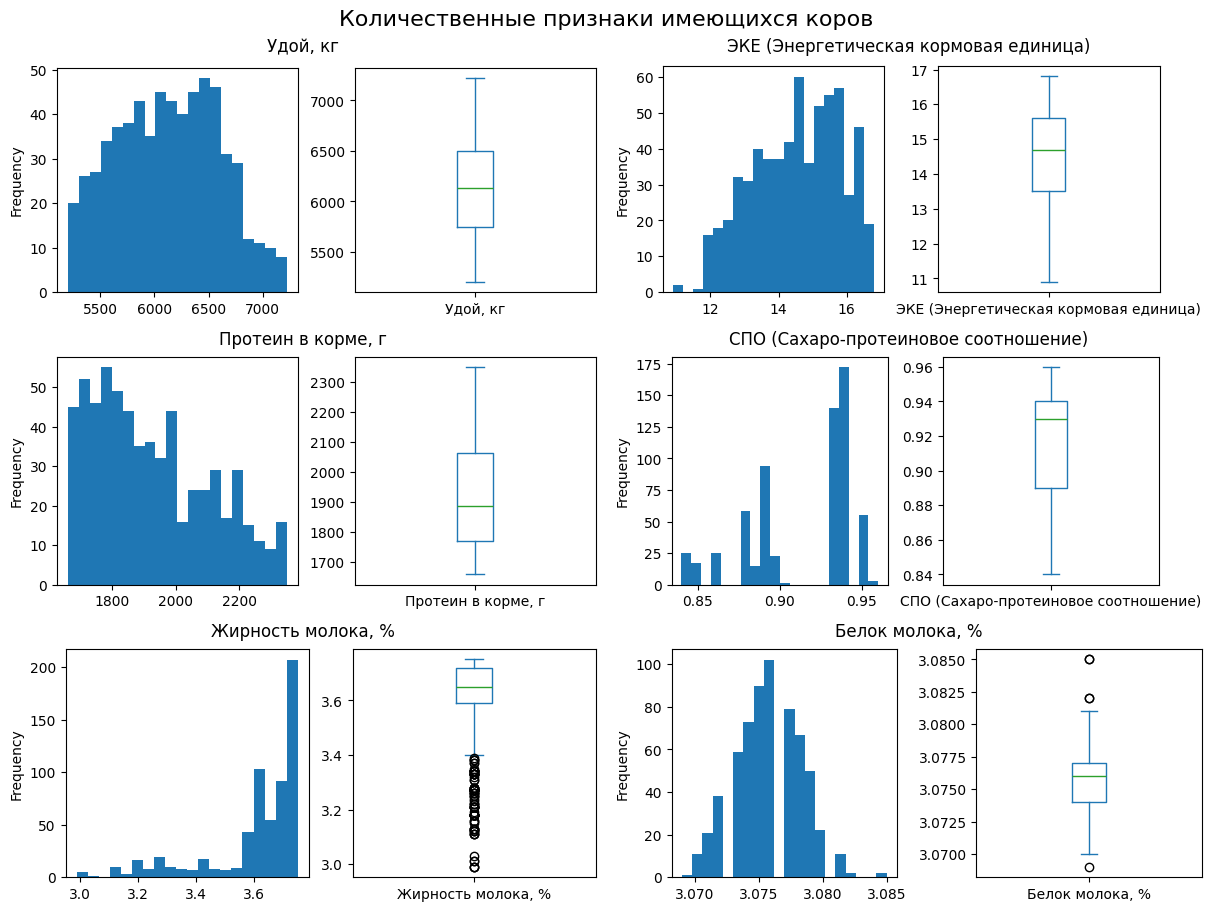

In [25]:
plot_numeric(df_main, get_num_cols(df_main), "Количественные признаки имеющихся коров")

В целом, выводы сделанные на основе описательных статистик подтверждаются. Дополнительно можно отметить следующие особенности данных:
* В СПО просматривается разделение значений на 3 группы, возможно это связано с каким-то из категориальных признаков.
* В жирности молока общая гистограмма тоже похожа на сумму двух гистограмм, что опять же может быть связано с влиянием одного из категориальных призанков. Изучим это далее.
* Для значений белка в молоке боксплот говорит о наличии небольшого количества выбросов, так как их количество незначительно, то можно их удалить.

In [26]:
df_main = df_main.query("3.069 < milk_protein < 3.082")

Посмотрим на распределения численных значений для доступных к покупке коров

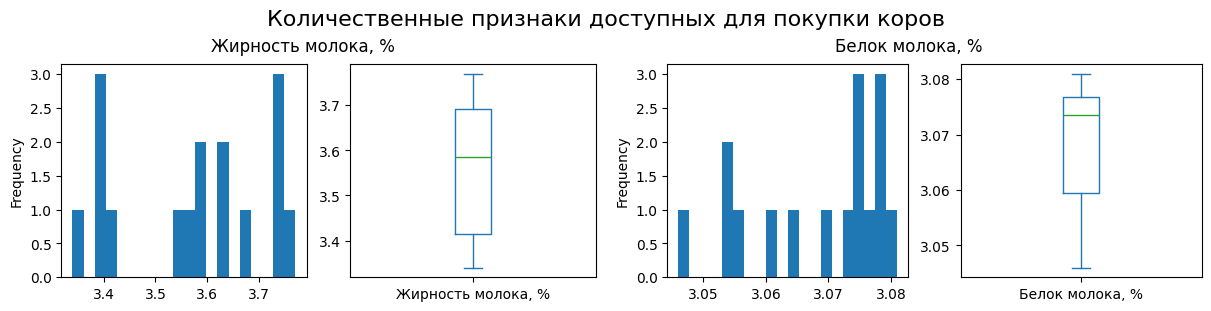

In [27]:
plot_numeric(
    df_buy,
    get_num_cols(df_buy, exclude_cols=[]),
    "Количественные признаки доступных для покупки коров",
)

В данном случае значений мало, о каких-то распределениях говорить сложно, выводы, сделанные на описательных статистиках подтверждаются.

Посмотрим теперь на категориальные данные.

Для начала создадим функцию для построения распределений категориальных данных.

In [28]:
def plot_cats(
    df: pd.DataFrame, cat_cols: list[str], title: str, ncols: int = 2
) -> None:
    """
    Функция для построения графиков распределения категориальных признаков.

    Параметры:
    ----------
    - df: DataFrame с данными.
    - cat_cols: Список категориальных признаков для анализа.
    - title: Заголовок для графиков.
    - ncols: Количество столбцов для размещения графиков.
    """

    scale = 2.5
    nrows = math.ceil(len(cat_cols) / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(scale * ncols * 1.5, scale * nrows))
    fig.suptitle(title, fontsize=16)
    try:
        axs = cast(Sequence[Axes], axs.flatten())
    except AttributeError:
        axs = cast(Sequence[Axes], [axs])
    for i, col in enumerate(cat_cols):
        data = df[col].rename(translator[col]).value_counts(ascending=True)
        data.plot(kind="barh", ax=axs[i], ylabel="", xlabel="Количество")
        axs[i].set_title(data.index.name)
    # Удалим лишние оси
    for i in range(len(cat_cols), nrows * ncols):
        axs[i].remove()
    fig.tight_layout()

Посмотрим на распределение категориальных признаков имеющихся коров

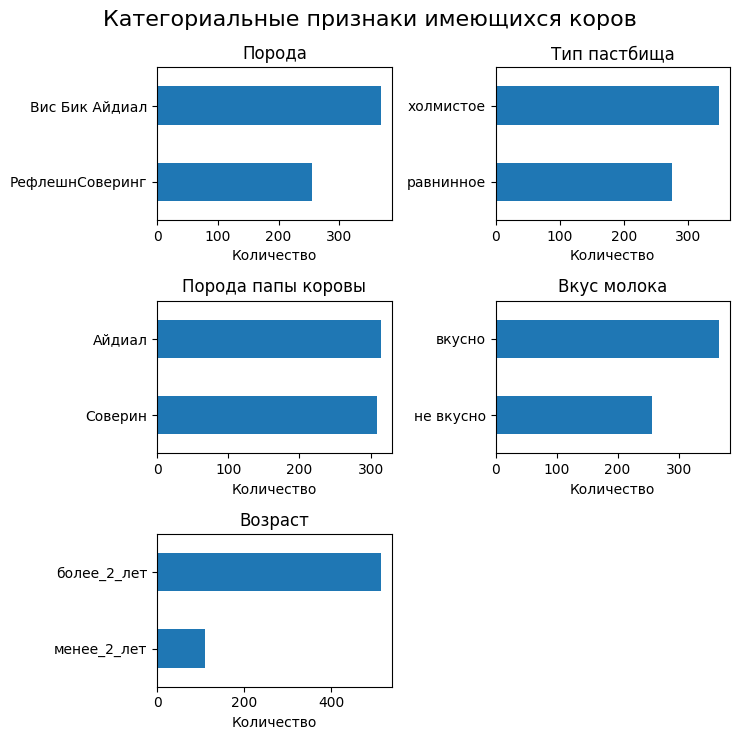

In [29]:
plot_cats(df_main, get_cat_cols(df_main), "Категориальные признаки имеющихся коров")

В целом, категориальные данные распределены более-менее равномерно для всех признаков за исключением возраста коров: коров моложе 2 лет значительно меньше, чем коров постарше.

Посмотрим на распределение пап коров.

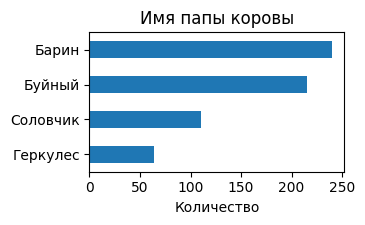

In [30]:
plot_cats(df_dads, ["dad_name"], title="", ncols=1)

Видны 2 лидера: "Барин" и "Буйный" и два аутсайдера: "Соловчик" и "Геркулес".

Посмотрим на распределение категориальных признаков коров, которые предлагаются для покупки.

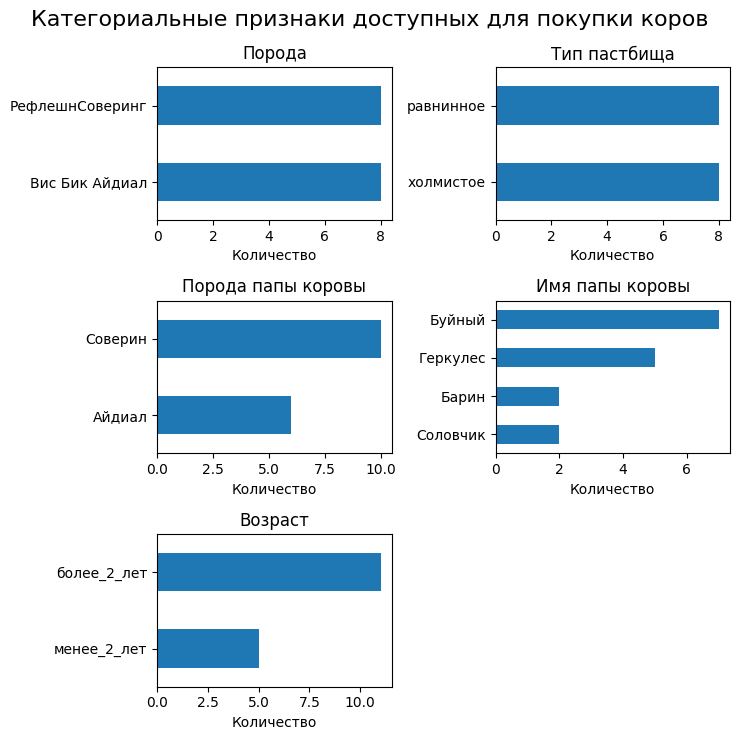

In [31]:
plot_cats(
    df_buy, get_cat_cols(df_buy), "Категориальные признаки доступных для покупки коров"
)

Несколько отличается распределение отцов предлагаемых коров, здесь уже "Геркус" среди лидеров, а "Барин" в аутсайдерах.

В остальном распределения категориальных признаков похожи на распределения признаков для уже имеющихся на ферме коров.

<a class="ancor" id="13-bullet"></a>
### Выводы

Исследовательский анализ данных выявил следующие особенности данных:

1. Коровы, имеющиеся на ферме:
   * Данные удоя, ЭКЕ и белка молока имеют близкие среднее и медианное значения, а также близкое к нормальному распределения.
   * Для всех данных СО значительно меньше средних значений, разброс данных не особо велик.
   * Сами данные имеют очень разные масштабы своих абсолютных значений.
   * В СПО просматривается разделение значений на 3 группы, возможно это связано с каким-то из категориальных признаков.
   * В жирности молока общая гистограмма тоже похожа на сумму двух гистограмм, что опять же может быть связано с влиянием одного из категориальных призанков. Изучим это далее.
   * Для значений белка в молоке боксплот говорит о наличии небольшого количества выбросов, которые были удалены.
   * Категориальные данные распределены более-менее равномерно для всех признаков за исключением возраста коров: коров моложе 2 лет значительно меньше, чем коров постарше.
   * Среди отцов коров выделяются 2 лидера: "Барин" и "Буйный" и два аутсайдера: "Соловчик" и "Геркулес".

2. Коровы, доступные для покупки:
   Коров для покупки в целом довольно мало, говорить о распределениях их параметров довольно сложно, но можно подметить общие тенденции:
   * СО значительно меньше центральных значений, поэтому разброс данных не особо велик.
   * Несколько отличается распределение отцов предлагаемых коров, здесь уже "Геркус" среди лидеров, а "Барин" в аутсайдерах.
   * В остальном распределения категориальных признаков похожи на распределения признаков для уже имеющихся на ферме коров.

[Оглавление](#0-bullet)

<a class="ancor" id="14-bullet"></a>
## 4. Статистический анализ

<a class="ancor" id="15-bullet"></a>
### Изучение взаимосвязи между признаками

Посмотрим на коэффициенты корреляции для числовых признаков имеющихся на ферме коров.

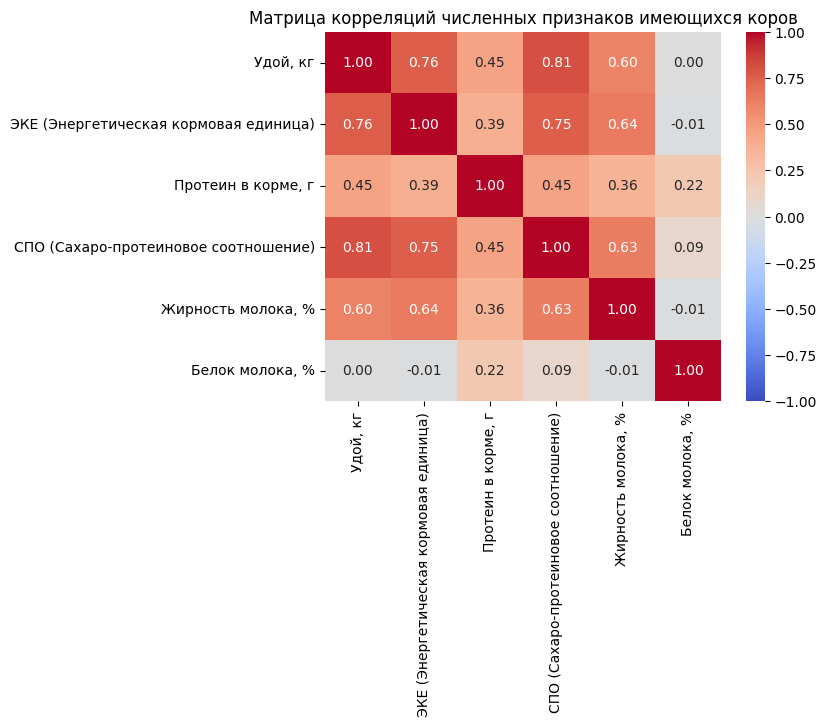

In [32]:
ax = sns.heatmap(
    df_main[get_num_cols(df_main)].rename(translator, axis=1).corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)
_ = ax.set_title("Матрица корреляций численных признаков имеющихся коров")

Построим еще матрицу корреляций используя все признаки, а не только численные. Для этого используем статистику [$\phi_k$](https://github.com/kaveio/phik?tab=readme-ov-file)

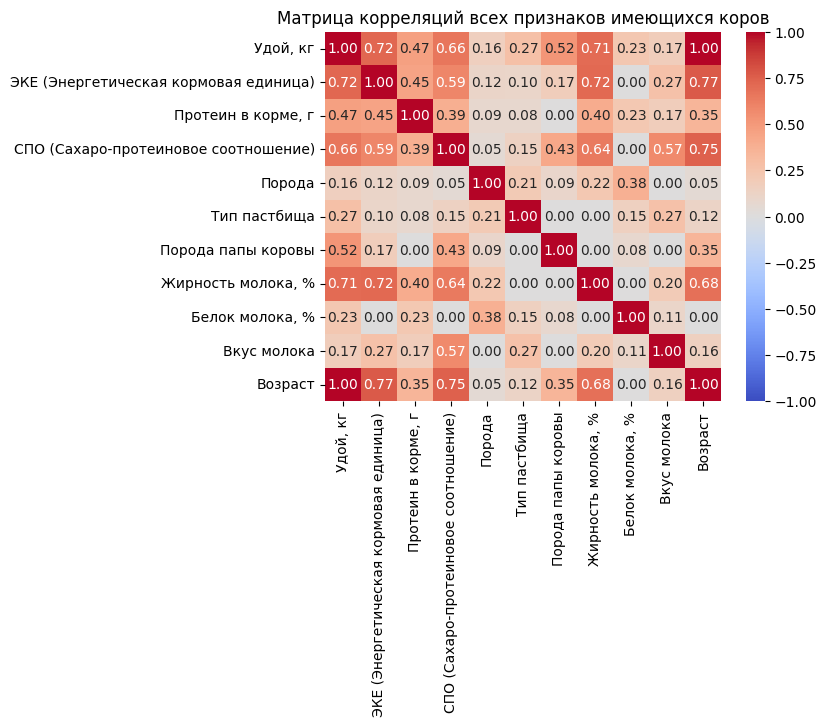

In [33]:
ax = sns.heatmap(
    df_main.drop("id", axis=1).rename(translator, axis=1).phik_matrix(verbose=False),  # type: ignore
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)
_ = ax.set_title("Матрица корреляций всех признаков имеющихся коров")

Выведем список наиболее значительных корреляций между признаками.

In [34]:
def highest_corrs(df: pd.DataFrame, cols: Optional[list[str]] = None, max_cols:int=10):
    """
    Функция для вычисления корреляций между парами числовых признаков

    Параметры:
    ----------
    - df: DataFrame с данными.
    - cols: Список числовых признаков для анализа.
    - max_cols: Количество выводимых значений.
    """
    corrs = dict()
    if cols is None:
        cols = list(df.columns)
    for comb in combinations(cols, 2):
        val = df[list(comb)].phik_matrix(verbose=False).values[0, 1]  # type: ignore
        key = (translator[comb[0]], translator[comb[1]])
        corrs[key] = round(val, 2)
    s = pd.DataFrame(
        data=corrs.values(), index=list(corrs.keys()), columns=["corrs"]
    ).sort_values(
        by="corrs", key=abs, ascending=False
    )  # type: ignore

    def signigicance(cor: float) -> str:
        cor = abs(cor)
        if cor < 0.25:
            return "отсутствует"
        if cor < 0.5:
            return "слабая"
        if cor < 0.75:
            return "средняя"
        return "сильная"

    s["значимость"] = s["corrs"].transform(signigicance)
    display(s.head(max_cols))

In [35]:
highest_corrs(df_main, cols=list(df_main.drop("id", axis=1).columns))

,corrs,значимость
"(Удой, кг, Возраст)",1.00,сильная
"(ЭКЕ (Энергетическая кормовая единица), Возраст)",0.77,сильная
"(СПО (Сахаро-протеиновое соотношение), Возраст)",0.75,сильная
"(ЭКЕ (Энергетическая кормовая единица), Жирность молока, %)",0.72,средняя
"(Удой, кг, ЭКЕ (Энергетическая кормовая единица))",0.72,средняя
"(Удой, кг, Жирность молока, %)",0.71,средняя
"(Жирность молока, %, Возраст)",0.68,средняя
"(Удой, кг, СПО (Сахаро-протеиновое соотношение))",0.66,средняя
"(СПО (Сахаро-протеиновое соотношение), Жирность молока, %)",0.64,средняя
"(ЭКЕ (Энергетическая кормовая единица), СПО (Сахаро-протеиновое соотношение))",0.59,средняя


* Самая сильная корреляция (1.0) наблиюдается между **удоем** и **возрастом**
* Сильные (>0.75) корреляции наблюдается между:
  * **возрастом** и **ЭКЕ**
  * **возрастом** и **СПО**
* Средняие (>0.5) корреляция наблюдается между:
  * **ЭКЕ** и **жирностью молока**
  * **удоем** и **ЭКЕ**
  * **удоем** и **жирностью молока**
  * **жирностью молока** и **возрастом**
  * **удоем** и **СПО**
  * **СПО** и **жирностью молока**
  * **ЭКЕ** и **СПО**
  * **СПО** и **вкусом** молока
  * **удоем** и **породой отца**

Получается, что коров постарше кормят получше. Лучшее качество коррелирует с большими удоями и жирностью молока.

<a class="ancor" id="16-bullet"></a>
### Построение диаграмм рассеяния удоя

Построим диаграммы рассеяния удоя и всех количественных признаков, учитывая при этом значения категориальных признаков.

In [36]:
def scatter_by_cat(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    cat_cols: list[str],
    ncols: int = 3,
) -> None:
    """
    Функция для построения графиков рассеяния с цветовой кодировкой по категориальным признакам.

    Параметры:
    ----------
    - df: DataFrame с данными.
    - x_col: Название столбца для оси X.
    - y_col: Название столбца для оси Y.
    - cat_cols: Список категориальных признаков для цветовой кодировки.
    - ncols: Количество столбцов для размещения графиков.
    """
    scale = 3.5
    nrows = math.ceil(len(cat_cols) / ncols)
    fig, axs = plt.subplots(
        nrows, ncols, figsize=(scale * ncols, scale * nrows), sharex=True, sharey=True
    )
    fig.suptitle(f"{translator[x_col]} vs {translator[y_col]}", fontsize=16)

    axs = cast(Sequence[Axes], axs.flatten())
    for i, col in enumerate(cat_cols):
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=col, ax=axs[i])
        axs[i].set_ylabel(translator[y_col])
        axs[i].set_xlabel(translator[x_col])
        axs[i].legend(title=translator[col])
    # Удалим лишние оси
    for i in range(len(cat_cols), nrows * ncols):
        axs[i].remove()
    plt.tight_layout()

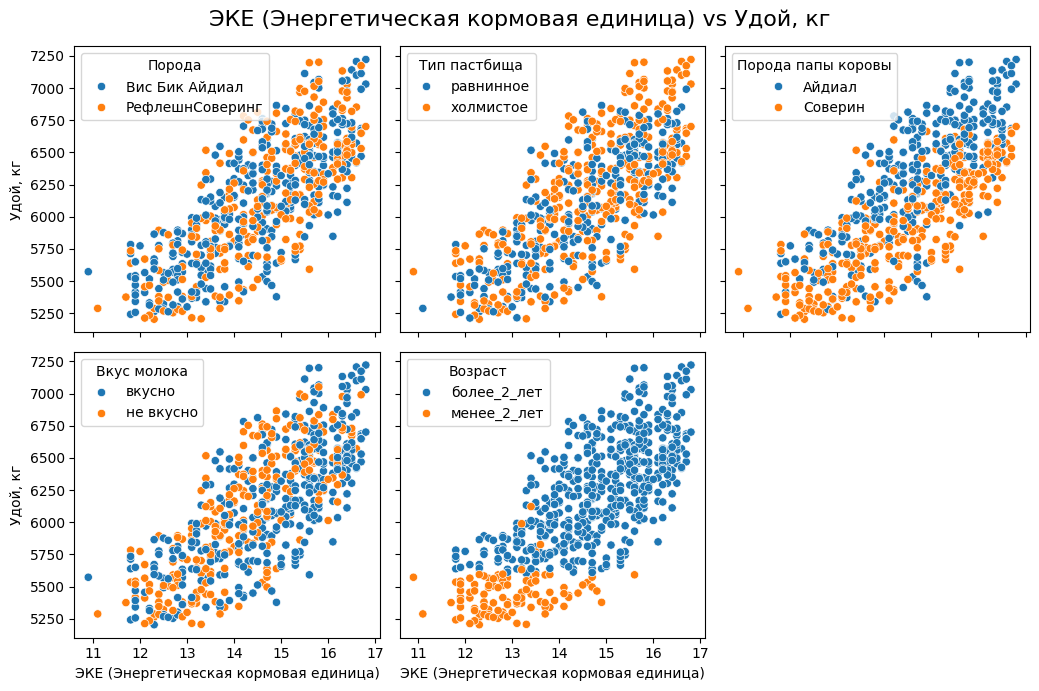

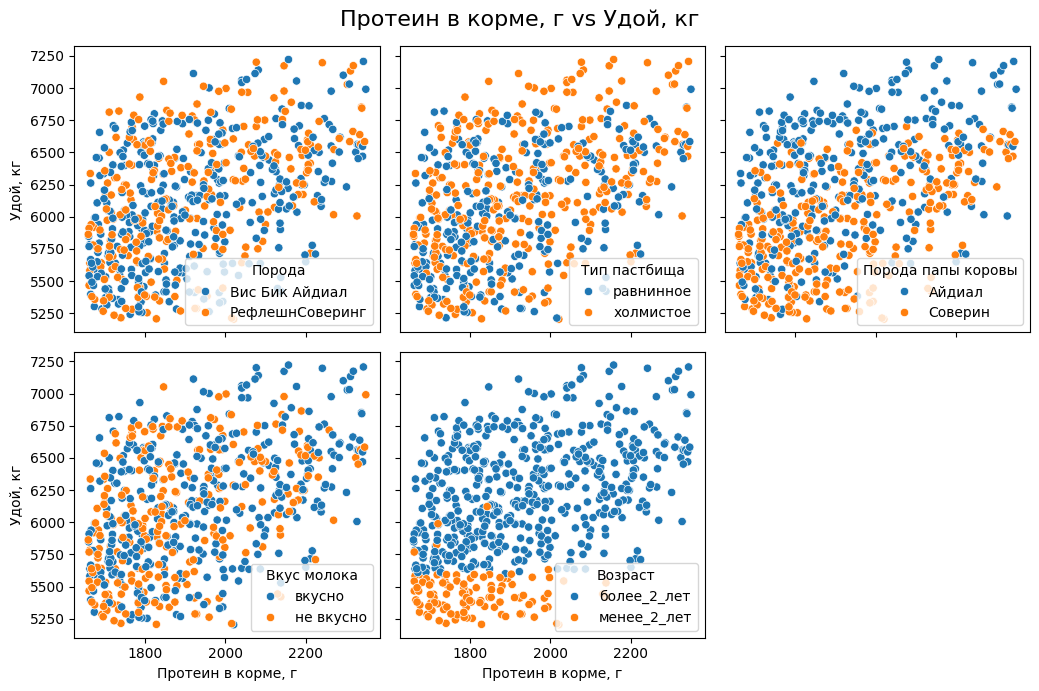

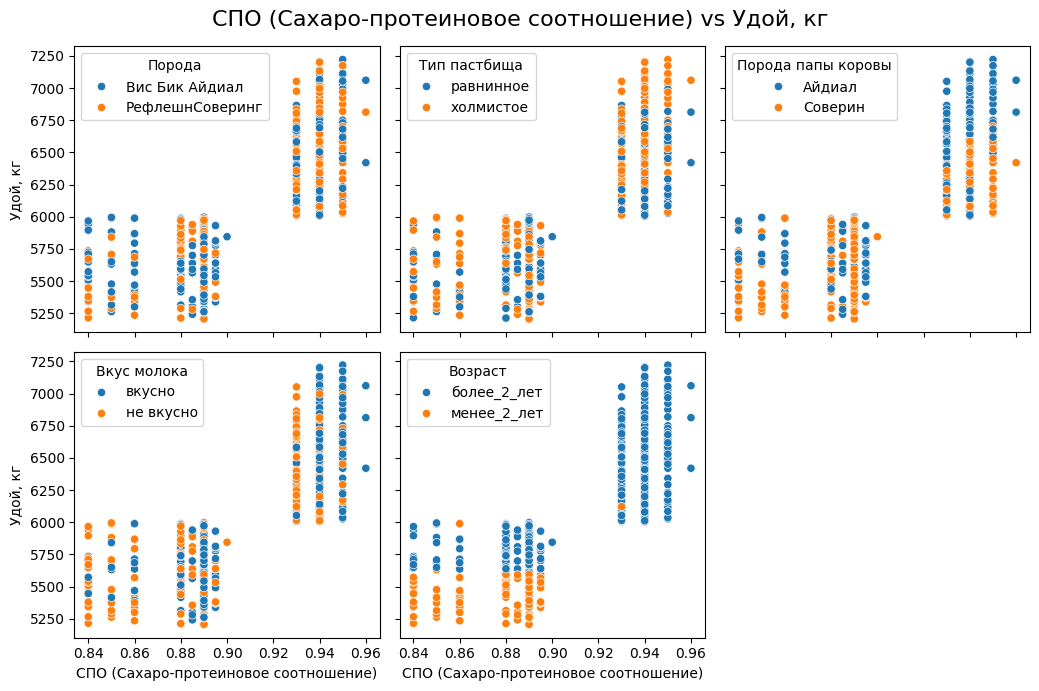

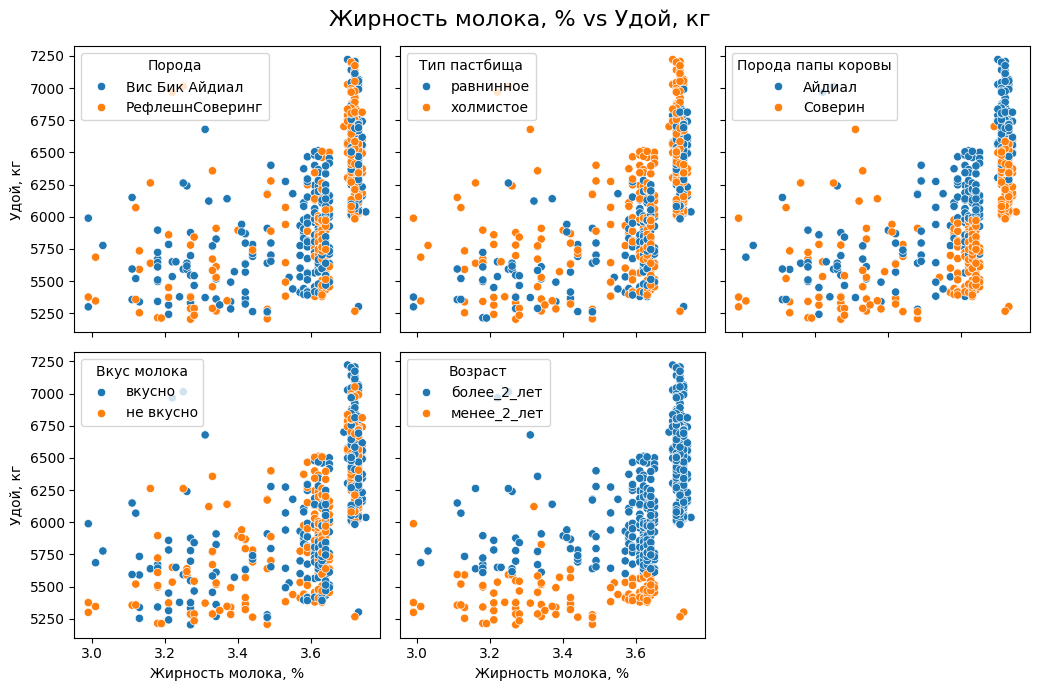

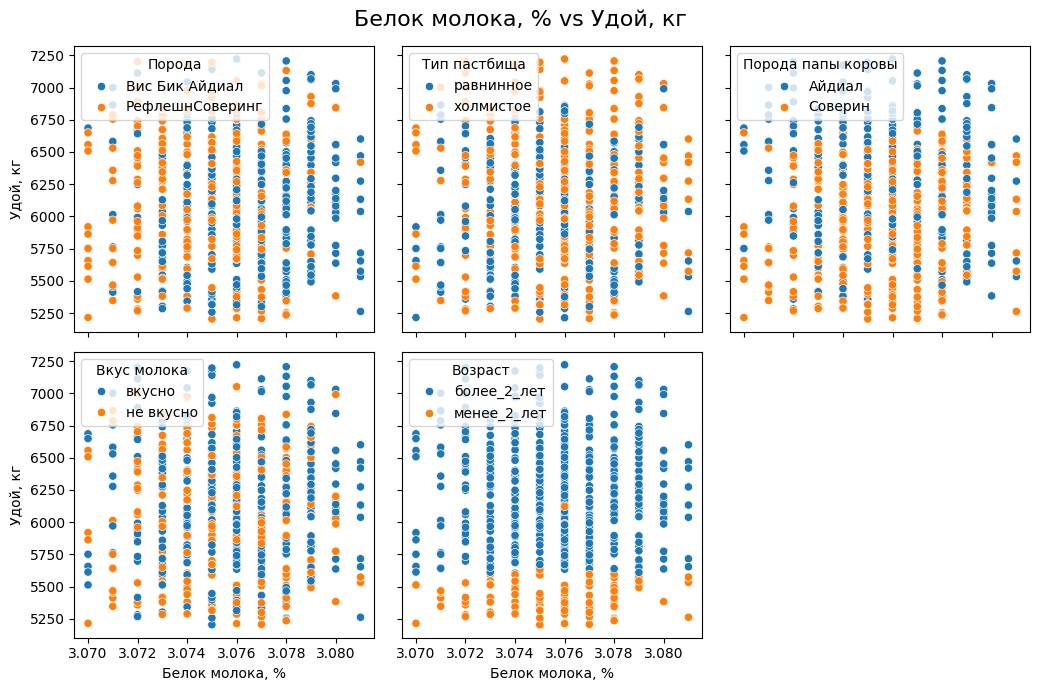

In [37]:
for cat in get_num_cols(df_main, ["id", "milk_yield"]):
    scatter_by_cat(df_main, cat, "milk_yield", get_cat_cols(df_main))

Анализ диаграмм рассеяния позволил выявить следующие закономерности:
1. Присутствует довольно сильная **близкая к линейной** корреляция между **удоем** и **энергетической кормовой единицей**. Коэффициент корреляции 0.76
2. Между **протеином в корме** и **удоем** прослеживается довольно **слабая линейная зависимость**. Коэффициент корреляции 0.47
3. Между **СПО** и **удоем** **линейной зависимости не прослеживается**, однако данные явно кластеризуются в 2 большие группы: Для СПО более 0.9 Удои составляют более 6000 кг, а для меньших СПО удои не превышают 6000 кг. Похоже, что СПО можно использовать как отсекающий фактор, так как по постановке задачи нам нужны коровы, способные давать более 6000 кг молока в год, поэтому не стоит рассматривать для покупки коров, у которых СПО менее 0.9. Также можно трасформировать СПО в категориальный признак по аналогичному алгоритму.
4. Между **жирностью молока** и **удоем** тоже **не прослеживается линейной зависимости**. Но можно выделить 2 кластера данных, в которых сосредоточено большинство данных. Жирность имеет два характерных значения: одно около 3.6%, а второе около 3.75% (а также равномерный хвост в сторону более низких значений, но таких коров не очень много), при этом для первого значения жирности удои составляют от 5300 до 6500 кг в год, а для второго от 6000 до 7250 кг. Можно подумать о введении дополнительного категориального параметра, принимающего значение True при превышение жирностью значения 3.7%, и False во всех остальных. Значение True будет однозначно означать, что ожидаемый удой таких коров будет превышать 6000 кг. Значение False при этом НЕ означает, что удой точно будет ниже 6000 кг.
5. Между содержанием **белка в молоке** и **удоем** **не прослеживается никакой взаимосвязи**.

Влияние категориальных параметров:
6. Коровы возрастом до 2 лет дают удои до примерно 5600 кг, а возрастом более 2 лет от этого значения. Поэтому возраст менее 2 лет можно использовать как отсекающий параметр, нас точно не интересуют такие коровы, так как они не способны дать более 6000 кг молока в год.
7. Коровы возрастом менее двух лет также дают молоко с СПО, не превышающим 0.9, тогда как для коровы постарше дают молоко с любым содержанием СПО.
8. Похоже, что коровы с папой породы "Айдиал" в среднем дают больше молока, чем коровы с папой породы "Соверин". Нужно протестировать эту гипотезу.
9. Похоже, что в молоке коров породы "РефлешнСоверинг" содержание белка в среднем меньше, чем в молоке коров породы "Вис Бик Айдиал".

Добавим категориальные признаки, обнаруженные в п. 2 и 3.

In [38]:
df_main["spo_type"] = df_main["spo"].transform(
    lambda x: "Высокое" if x > 0.9 else "Низкое"
)
df_main["milk_fat_type"] = df_main["milk_fat"].transform(
    lambda x: "Высокое" if x > 3.65 else "Низкое"
)
translator.update({"spo_type": "Тип СПО", "milk_fat_type": "Тип жирности молока"})

Кроме того, при разбивке по категории возраста явно выделяется небольшое количество коров возрастом менее 2 лет, и имеющих при этом слишком большое значение удоя. Эти данные очень похожи на выбросы, удалим их.

In [39]:
df_main = df_main.drop(
    df_main.query('age == "менее_2_лет" and milk_yield > 5750').index
).reset_index(drop=True)

<a class="ancor" id="17-bullet"></a>
### Тесты статистических гипотез

Проведём тесты статистических гипотез о влиянии категориальных признаков на удой.

Влияние возраста, типов СПО и жирности молока статистически тестировать не будем, их влияние очевидно.

Для начала создадим пару функций для удобства проведения тестов.

In [40]:
def make_plot_groups(
    df: pd.DataFrame, cat: str, values: str, title: str
) -> list[pd.Series]:
    """
    Функция для построения гистограмм распределения числого признака в разбивке
    по заданному категориальному признаку.

    Параметры:
    ----------
    - df: DataFrame с данными.
    - cat: Название категориального признака для группировки.
    - values: Название числового признака для построения гистограммы.
    - title: Заголовок для графиков.
    """

    ngroups = df[cat].unique().size
    groups = []
    for i, group in enumerate(df[cat].unique()):
        groups.append(df[df[cat] == group][values])

    fig, axs = plt.subplots(1, ngroups, figsize=(4.5 * ngroups, 4))
    fig.suptitle(title, fontsize=16)
    bins = 30
    for i in range(ngroups):
        groups[i].plot(kind="hist", ax=axs[i], bins=bins, xlabel=translator[values])
        axs[i].set_title(df[cat].unique()[i])
    return groups


def stat_test(
    groups: Sequence[pd.Series],
    test: Callable,
    alternative: str = "two-sided",
    alpha: float = 0.05,
) -> None:
    """
    Функция для проведения статистического теста между группами.

    Параметры:
    ----------
    - groups: Тестируемые выборки.
    - test: Функция для проведения статистического теста (например, ttest_ind или mannwhitneyu).
    - alternative: Альтернативная гипотеза для теста (по умолчанию "two-sided").
    - alpha: Уровень значимости для проверки нулевой гипотезы (по умолчанию 0.05).

    """
    result = test(*groups, alternative=alternative)
    if result.pvalue >= alpha:
        print(
            f"Данные НЕ позволяют отвергнуть нуль гипотезу (p-value = {result.pvalue:.2e})"
        )
    else:
        print(
            f"Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = {result.pvalue:.2e})"
        )

Посмотрим на распределения удоем в разбивке по различным категориальным признакам.

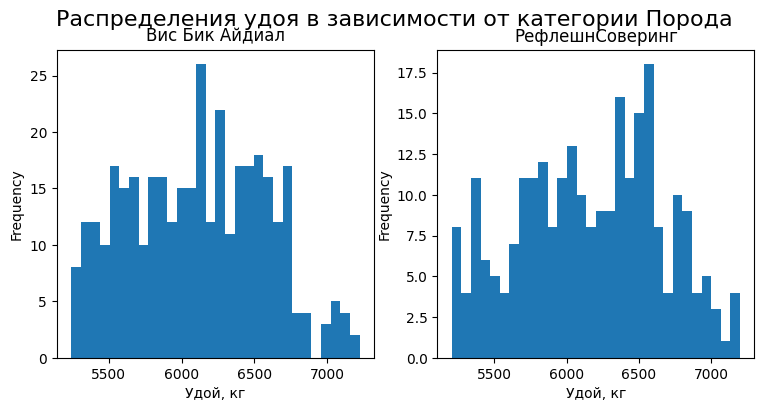

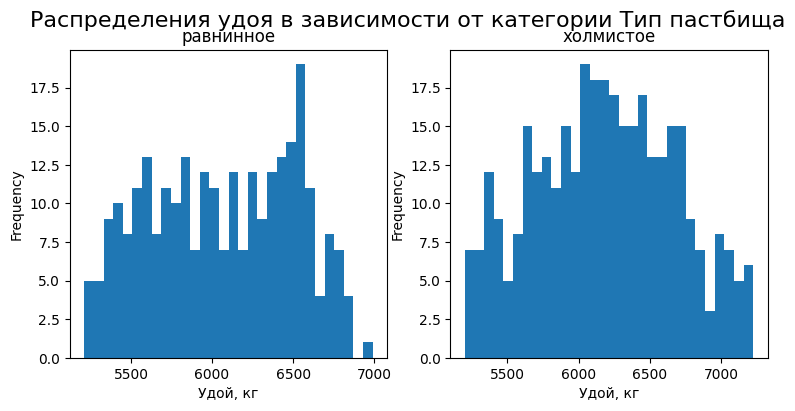

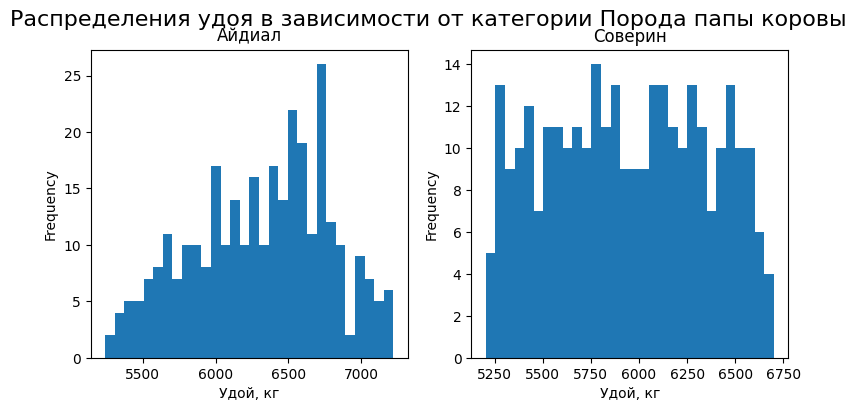

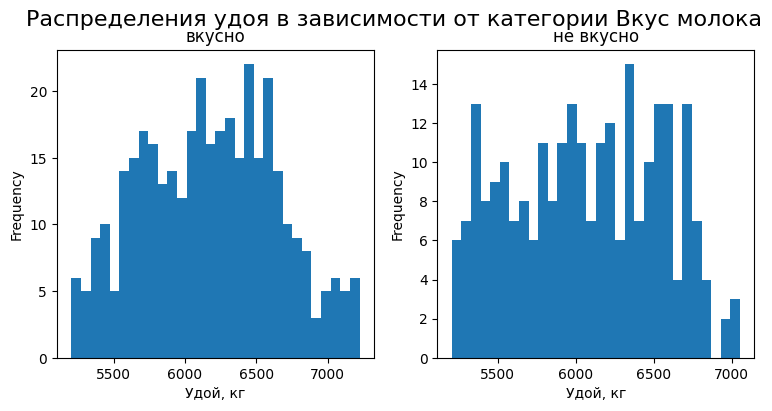

In [41]:
groups = {}
for cat in get_cat_cols(df_main, exclude_cols=["age", "spo_type", "milk_fat_type"]):
    groups.update(
        {
            cat: make_plot_groups(
                df_main,
                cat,
                "milk_yield",
                f"Распределения удоя в зависимости от категории {translator[cat]}",
            )
        }
    )

Во всех случаях распределения не особо сильно отклонаяются от нормальности, но для подстраховки можно проводить и тест Стьюдента и тест Манна-Уитни.

Во всех случаях будем тестировать аналогичные гипотезы.

**Нуль-гипотеза**: Распределение значений удоев коров в первой группе не отличается от распределения значения удоев коров во второй группе. (Для теста Стьюдента под распределением имеется ввиду его среднее значение, а для теста Манна-Уитни общее "положение" распределения).

**Альтернативная гипотеза**: Распределения удоев коров в группах **различается** (двусторонний тест).

**Уровень статистической значимости**: 0.05

In [42]:
alpha = 0.05
for cat, data in groups.items():
    print(f"* Влияние категории {translator[cat]}:")
    print("Тест стьюдента: ", end="")
    stat_test(data, ttest_ind, alpha=alpha)
    print("Тест Манна-Уитни: ", end="")
    stat_test(data, mannwhitneyu, alpha=alpha)
    print()

* Влияние категории Порода:
Тест стьюдента: Данные НЕ позволяют отвергнуть нуль гипотезу (p-value = 1.39e-01)
Тест Манна-Уитни: Данные НЕ позволяют отвергнуть нуль гипотезу (p-value = 1.22e-01)

* Влияние категории Тип пастбища:
Тест стьюдента: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 1.52e-03)
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 4.23e-03)

* Влияние категории Порода папы коровы:
Тест стьюдента: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 4.10e-24)
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 1.05e-21)

* Влияние категории Вкус молока:
Тест стьюдента: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 5.19e-03)
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 1.14e-02)



Нас также интересует вкус молока, поэтому проведём статистические тесты для выявления влияния на него других признаков.

Начнём с численных признаков и посмотрим на их распределения для вкусного и не вкусного молока.

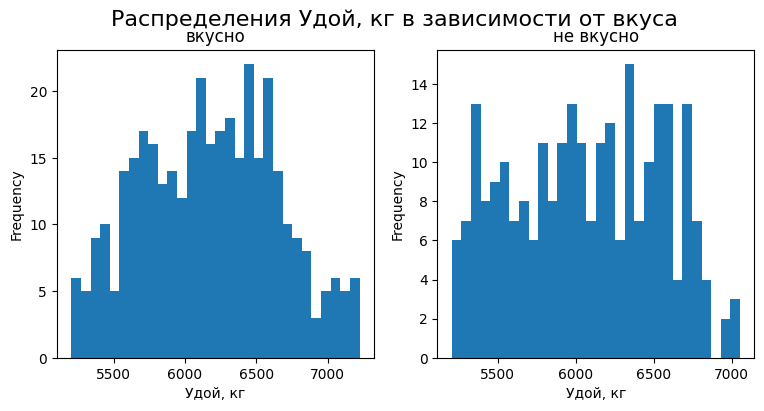

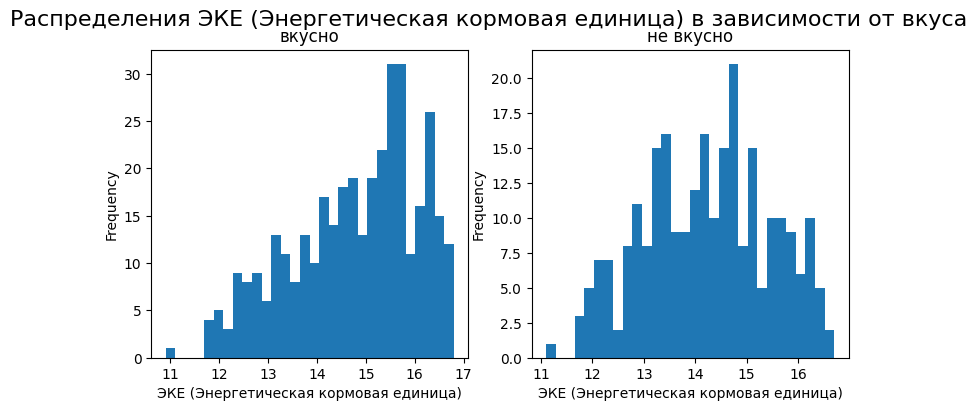

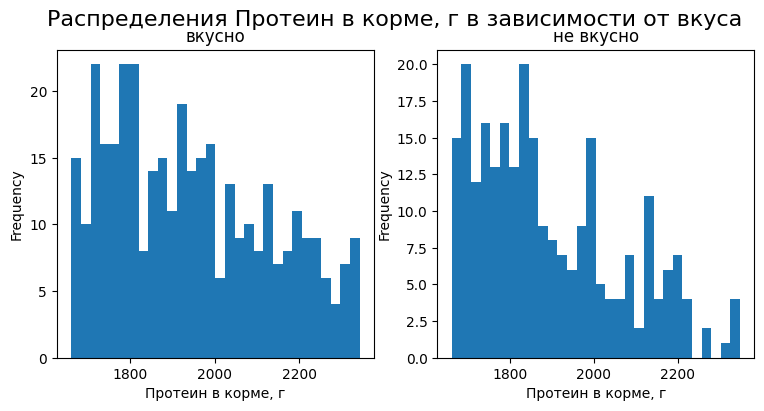

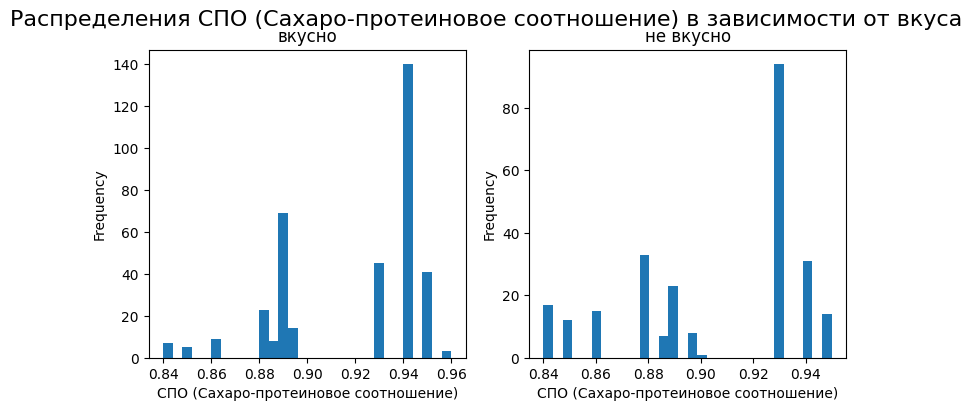

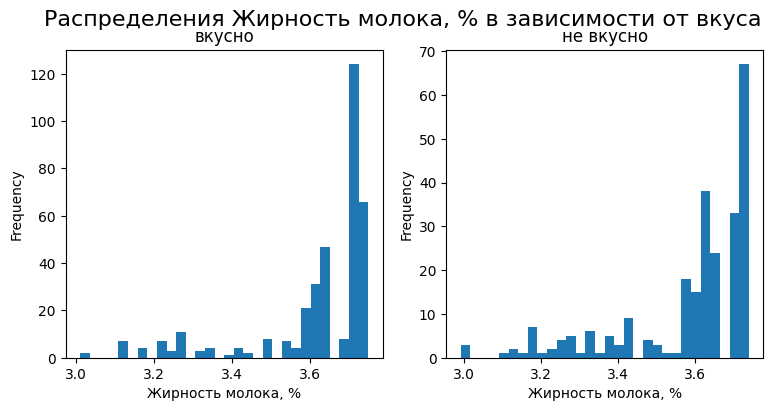

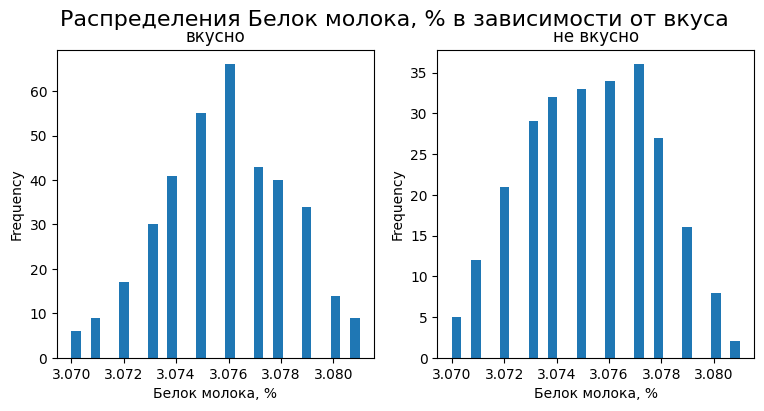

In [43]:
groups = {}
for feat in get_num_cols(df_main):
    groups.update(
        {
            feat: make_plot_groups(
                df_main,
                "milk_taste",
                feat,
                f"Распределения {translator[feat]} в зависимости от вкуса",
            )
        }
    )

Из всех распределений только распределения белка в молоке и удоя близки к нормальному, остальные сильно отличаются от нормальности.

Будем использовать тест Манна-Уитни во всех случаях для унификации.

Во всех случаях будет тестировать аналогичные гипотезы.

**Нуль-гипотеза**: Положение распределения численного признака для вкусного молока не отличается от положения распределения численного признака для не вкусного молока

**Альтернативная гипотеза**: Положения распределения численного признака для вкусного и не вкусного молока **различаются** (двусторонний тест).

**Уровень статистической значимости**: 0.05

In [44]:
alpha = 0.5
for cat, data in groups.items():
    print(f"* {translator[cat]}:")
    print("Тест Манна-Уитни: ", end="")
    stat_test(data, mannwhitneyu, alpha=alpha)
    print()

* Удой, кг:
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 1.14e-02)

* ЭКЕ (Энергетическая кормовая единица):
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 2.31e-08)

* Протеин в корме, г:
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 3.85e-04)

* СПО (Сахаро-протеиновое соотношение):
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 5.15e-11)

* Жирность молока, %:
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 5.57e-04)

* Белок молока, %:
Тест Манна-Уитни: Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 8.80e-03)



Для категориальных признаков будем проводить тест хи-квадрат с использованием таблиц сопряженности.

Во всех случаях будем тестировать аналогичные гипотезы.

**Нуль-гипотеза**: Частоты значений категориального признака для вкусного и не вкусного молока совпадают

**Альтернативная гипотеза**: Частоты значений категориального признака для вкусного и не вкусного молока **различаются** (двусторонний тест).

**Уровень статистической значимости**: 0.05

In [45]:
alpha = 0.05
for cat in get_cat_cols(df_main, exclude_cols=["milk_taste"]):
    print(f"* {translator[cat]}:")
    result = chi2_contingency(pd.crosstab(df_main["milk_taste"], df_main[cat]))
    if result.pvalue >= alpha:  # type: ignore
        print(
            f"Данные НЕ позволяют отвергнуть нуль гипотезу (p-value = {result.pvalue:.2e})"  # type: ignore
        )
    else:
        print(
            f"Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = {result.pvalue:.2e})"  # type: ignore
        )
    print()

* Порода:
Данные НЕ позволяют отвергнуть нуль гипотезу (p-value = 9.27e-01)

* Тип пастбища:
Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 1.85e-05)

* Порода папы коровы:
Данные НЕ позволяют отвергнуть нуль гипотезу (p-value = 9.81e-01)

* Возраст:
Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 7.71e-03)

* Тип СПО:
Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 4.42e-02)

* Тип жирности молока:
Данные позволяют отвергнуть нуль-гипотезу в пользу альтернативной гипотезы (p-value = 2.74e-04)



<a class="ancor" id="18-bullet"></a>
### Выводы

Был проведён статистический анализ взаимосвязи между признаками данных об имеющихся коровах.

1. Корреляционный показал следующие результаты:
    * Самая сильная корреляция (1.0) наблиюдается между **удоем** и **возрастом**
   * Сильные (>0.75) корреляции наблюдается между:
     * **возрастом** и **ЭКЕ**
     * **возрастом** и **СПО**
   * Средняие (>0.5) корреляция наблюдается между:
     * **ЭКЕ** и **жирностью молока**
     * **удоем** и **ЭКЕ**
     * **удоем** и **жирностью молока**
     * **жирностью молока** и **возрастом**
     * **удоем** и **СПО**
     * **СПО** и **жирностью молока**
     * **ЭКЕ** и **СПО**
     * **СПО** и **вкусом** молока
     * **удоем** и **породой отца**
2. Анализ диаграмм рассеяния позволил выявить следующие закономерности:
   1. Присутствует довольно сильная **близкая к линейной** корреляция между **удоем** и **энергетической кормовой единицей**.
   2. Между **протеином в корме** и **удоем** прослеживается довольно **слабая линейная зависимость**.
   3. Между **СПО** и **удоем** **линейной зависимости не прослеживается**, однако данные явно кластеризуются в 2 большие группы: Для СПО более 0.9 Удои составляют более 6000 кг, а для меньших СПО удои не превышают 6000 кг. Похоже, что СПО можно использовать как отсекающий фактор, так как по постановке задачи нам нужны коровы, способные давать более 6000 кг молока в год, поэтому не стоит рассматривать для покупки коров, у которых СПО менее 0.9.
   В датафрейм добавлен категориальный признак `spo_type`, имеющий значение `Высокое` для значений СПО, превышающих 0.9, и `Низкое` в остальных случаях.
   4. Между **жирностью молока** и **удоем** тоже **не прослеживается линейной зависимости**. Но можно выделить 2 кластера данных, в которых сосредоточено большинство данных. Жирность имеет два характерных значения: одно около 3.6%, а второе около 3.75% (а также равномерный хвост в сторону более низких значений, но таких коров не очень много), при этом для первого значения жирности удои составляют от 5300 до 6500 кг в год, а для второго от 6000 до 7250 кг. В датафрейм добавлен категориальный признак, принимающий значение `Высокое` при превышение жирностью значения 3.65%, и `Низкое` во всех остальных.
   5. Между содержанием **белка в молоке** и **удоем** **не прослеживается никакой взаимосвязи**.
   6. Коровы возрастом до 2 лет дают удои до примерно 5600 кг, а возрастом более 2 лет от этого значения. Поэтому возраст менее 2 лет можно использовать как отсекающий параметр, нас точно не интересуют такие коровы, так как они не способны дать более 6000 кг молока в год.
   7. Коровы возрастом менее двух лет также дают молоко с СПО, не превышающим 0.9, тогда как для коровы постарше дают молоко с любым содержанием СПО.
3. Проверка статистических гипотез о влиянии категориальных признаков на **удой** дал следующие результаты:
   1. Данные **не** позволяют отвергнуть гипотезу об **отсутствии** влияния **породы коров** на величину удоя.
   2. Данные **позволяют** отвергнуть гипотезу об **отсутствии** влияния **типа пастбища** на величину удоя.
   3. Данные **позволяют** отвергнуть гипотезу об **отсутствии** влияния **породы отца коровы** на величину удоя.
   4. Данные **позволяют** отвергнуть гипотезу об **отсутствии** влияния **вкуса молока** на величину удоя.
4. Проверка статистических гипотез о влиянии признаков на **вкус молока** дал следующие результаты:
   1. Данные **позволяют** отвергнуть гипотезу о равенстве положения распределений каждого из численных призанков (удой, ЭКЕ, протеин в корме, СПО, жирность и белок молока) для вкусного и не вкусного молока.
   2. Данные **не** позволяют гипотезу о равенстве частот значений **породы коровы** и **породы отца коровы** для вкусного и невкусного молока.
   3. Данные **позволяют** гипотезу о равенстве частот значений **типа пастбища**, **возраста**, **типа СПО** и **типа жирности молока** для вкусного и невкусного молока.

[Оглавление](#0-bullet)

<a class="ancor" id="19-bullet"></a>
## 5. Обучение моделей линейной регрессии

Создадим класс для хранения результатов и несколько функций для удобства обучения модели и анализа её результатов

In [46]:
@dataclass
class FitResult:
    """
    Класс для хранения результатов обучения модели и метрик качества.
    """

    y_test: pd.Series
    X_test: pd.DataFrame
    model_name: str
    model: Union[LinearRegression, LogisticRegression]
    num_scaler: StandardScaler
    cat_scaler: OneHotEncoder
    pos_label: str = ""
    regr_metrics: list[str] = field(
        default_factory=lambda: ["r2_score", "mae", "mse", "rmse", "mape"]
    )
    class_metrics: list[str] = field(
        default_factory=lambda: ["accuracy", "precision", "recall"]
    )

    @property
    def predicted(self) -> pd.Series:
        return pd.Series(self.model.predict(self.X_test), index=self.y_test.index)

    @property
    def r2_score(self) -> float:
        return self._get_metric(r2_score)

    @property
    def mae(self) -> float:
        return self._get_metric(mean_absolute_error)

    @property
    def mse(self) -> float:
        return self._get_metric(mean_squared_error)

    @property
    def rmse(self) -> float:
        return self._get_metric(root_mean_squared_error)

    @property
    def mape(self) -> float:
        return self._get_metric(mean_absolute_percentage_error)

    @property
    def accuracy(self) -> float:
        return self._get_metric(accuracy_score)

    @property
    def precision(self) -> float:
        return self._get_metric(precision_score)

    @property
    def recall(self) -> float:
        return self._get_metric(recall_score)

    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Преобразует входные данные с помощью стандартизации числовых признаков и кодирования категориальных признаков.
        """
        return pd.DataFrame(
            data=np.concatenate(
                (
                    self.num_scaler.transform(data[self.num_scaler.feature_names_in_]),
                    self.cat_scaler.transform(data[self.cat_scaler.feature_names_in_]),  # type: ignore
                ),
                axis=1,
            ),  # type: ignore
            columns=(
                list(self.num_scaler.get_feature_names_out())
                + list(self.cat_scaler.get_feature_names_out())
            ),
        )

    def predict(self, data: pd.DataFrame) -> pd.Series:
        """
        Выполняет предсказание на основе входных данных.
        """
        prediction = self.model.predict(self.transform(data))
        return pd.Series(prediction, index=data.index)

    def score(self) -> None:
        """
        Вычисляет и выводит метрики качества модели на тестовых данных.
        """
        if isinstance(self.model, LinearRegression):
            self._get_regression_metrics()
        elif isinstance(self.model, LogisticRegression):
            self._get_classification_metric()

    def _get_regression_metrics(self) -> None:

        for metric in self.regr_metrics:
            print(f"{metric.upper()}: {getattr(self, metric):.3f}")

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(f"Распределение остатков. {self.model_name}")
        (self.y_test - self.predicted).plot(kind="hist", ax=axes[0], bins=20)
        axes[0].set_xlabel("Остатки")
        (
            pd.concat((self.y_test, self.y_test - self.predicted), axis=1)
            .set_axis(labels=[translator["milk_yield"], "Остатки"], axis=1)
            .plot(kind="scatter", x=translator["milk_yield"], y="Остатки", ax=axes[1])
        )

    def _get_classification_metric(self) -> None:

        for metric in self.class_metrics:
            print(f"{metric.capitalize()}: {getattr(self, metric):.3f}")

        matrix = confusion_matrix(self.y_test, self.predicted)
        labels = [
            self.pos_label,
            set(self.predicted).difference([self.pos_label]).pop(),
        ]
        ax = sns.heatmap(
            matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels
        )
        ax.set_title(f"Матрица ошибок. {self.model_name}")
        ax.set_xlabel("Предсказано")
        ax.set_ylabel("Истинно")

    def _get_metric(self, metric_func: Callable) -> float:
        try:
            return cast(
                float,
                metric_func(self.y_test, self.predicted, pos_label=self.pos_label),
            )
        except TypeError:
            return cast(float, metric_func(self.y_test, self.predicted))
        else:
            return math.inf


def split_and_scale(
    X: pd.DataFrame, y: pd.Series
) -> tuple[
    pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, StandardScaler, OneHotEncoder
]:
    """
    Функция для разделения данных на обучающую и тестовую выборки, а также для стандартизации числовых признаков

    Параметры:
    ----------
    - X: DataFrame с признаками.
    - y: Series с целевым признаком.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    num_cols = X.select_dtypes(np.number).columns
    cat_cols = X.select_dtypes(object).columns

    ohe = OneHotEncoder(drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train[cat_cols])
    X_test_ohe = ohe.transform(X_test[cat_cols])
    cat_cols_ohe = ohe.get_feature_names_out()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_cols])
    X_test_scaled = scaler.transform(X_test[num_cols])

    X_train = pd.DataFrame(
        data=np.concatenate((X_train_scaled, X_train_ohe), axis=1),
        columns=list(num_cols) + list(cat_cols_ohe),
    )
    X_test = pd.DataFrame(
        data=np.concatenate((X_test_scaled, X_test_ohe), axis=1),  # type: ignore
        columns=list(num_cols) + list(cat_cols_ohe),
    )
    return X_train, X_test, y_train, y_test, scaler, ohe


def model_fit(
    data: pd.DataFrame,
    target: str,
    features: Sequence[str],
    model: type[Union[LinearRegression, LogisticRegression]],
    name: str,
    pos_label: str = "",
) -> FitResult:
    """
    Функция для обучения модели линейной регрессии и получения предсказаний.

    Параметры:
    ----------
    - data: DataFrame с данными.
    - target: Название целевого признака.
    - features: Список признаков для обучения модели.
    - model: Класс модели для обучения.
    - name: Название модели для идентификации в результатах.
    - pos_label: Метка для положительного класса в случае классификации.
    """

    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test, scaler, ohe = split_and_scale(X, y)
    slm = model()
    slm.fit(X_train, y_train)
    return FitResult(
        y_test=y_test,
        X_test=X_test,
        model_name=name,
        model=slm,
        num_scaler=scaler,
        cat_scaler=ohe,
        pos_label=pos_label,
    )


def fit_and_score(
    data: pd.DataFrame,
    target: str,
    features: Sequence[str],
    model: type[Union[LinearRegression, LogisticRegression]],
    name: str,
    pos_label: str = "",
) -> FitResult:
    """
    Функция для обучения модели линейной регрессии, получения предсказаний и вывода метрик.

    Параметры:
    ----------
    - data: DataFrame с данными.
    - target: Название целевого признака.
    - features: Список признаков для обучения модели.
    - model: Класс модели для обучения.
    - name: Название модели для идентификации в результатах.
    - pos_label: Метка для положительного класса в случае классификации.
    """
    fit_result = model_fit(data, target, features, model, name, pos_label)
    fit_result.score()
    return fit_result

<a class="ancor" id="20-bullet"></a>
### Базовая модель
Для первой базовой модели просто используем все имеющиеся признаки (за исключением spo_type и milt_fat_type, введённых на прошлом этапе).

Также исключим вкус молока, так как для покупаемых коров этот параметр неизвестен.

R2_SCORE: 0.839
MAE: 142.174
MSE: 33945.659
RMSE: 184.243
MAPE: 0.024


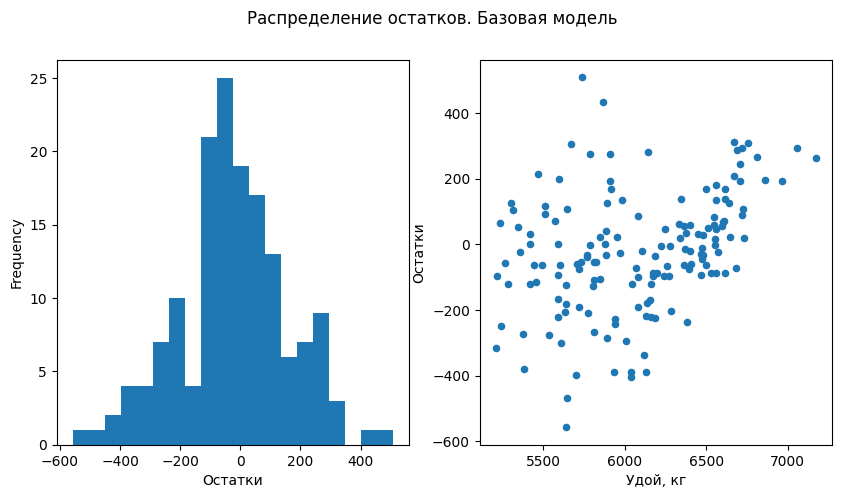

In [47]:
target = "milk_yield"
features = list(
    df_main.columns.difference(
        [target, "id", "spo_type", "milk_fat_type", "milk_taste"]
    )
)
base_model = fit_and_score(
    df_main, "milk_yield", features, LinearRegression, "Базовая модель"
)

Гистограмма распределения остатков немного смещена влево, модель имеет тенденцию переоценивать значения удоев.

Дисперсия остатков также неравномерна, после 6000 кг наблюдается сокращение дисперсии и смещение среднего значения остатков в положительную область, т.е. для больших удоев модель недооценивает предсказываемые удои.

<a class="ancor" id="21-bullet"></a>
### Модель со статистически значимыми признаками

На предыдущем этапе было установлено, что среди численных признаков линейная зависимость удоя наблюдается от энергетической ценности корма и содержанием белка в корме.

От СПО и жирности молока зависимость есть, хоть и нелинейная. Пока исользуем эти данные нелианеризированном виде.

Среди категориальных признаков статистически значимо влияют на удой возраст, тип пастбища и порода отца коровы

R2_SCORE: 0.836
MAE: 143.337
MSE: 34540.016
RMSE: 185.849
MAPE: 0.024


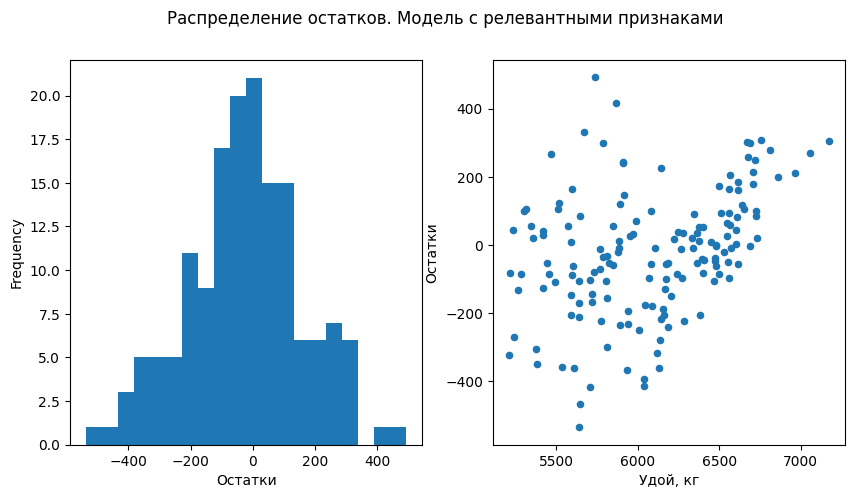

In [48]:
features = [
    "meal_value",
    "meal_protein",
    "spo",
    "milk_fat",
    "age",
    "dad_breed",
    "pasture",
]
model_1 = fit_and_score(
    df_main,
    "milk_yield",
    features,
    LinearRegression,
    "Модель с релевантными признаками",
)

Значения всех метрик ухудшились, характер распределения остатков остался неизменным.

<a class="ancor" id="22-bullet"></a>
### Модель с линеаризированными признаками

СПО и жирность молока явно нелинейно влияют на удой и на прошлом этапе уже были введены соответствующие категориальные признаки, используем их в этот раз.

Кроме того, зависимость удоя от ЭКЕ не вполне линейна, попробуем добавить новый признак, являющийся квадратом ЭКЕ.

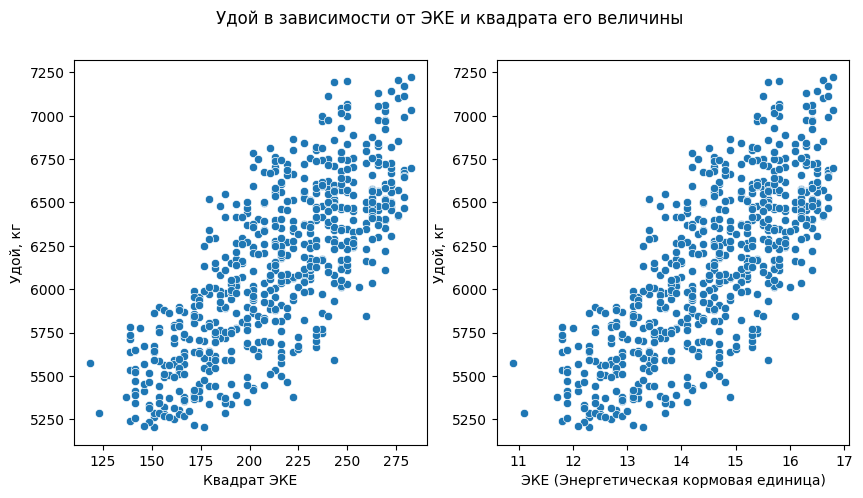

In [49]:
df_main["meal_value_squared"] = df_main["meal_value"].pow(2)
translator.update({"meal_value_squared": "Квадрат ЭКЕ"})

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Удой в зависимости от ЭКЕ и квадрата его величины")
for i, col in enumerate(["meal_value_squared", "meal_value"]):
    sns.scatterplot(df_main, x=col, y="milk_yield", ax=axes[i])
    axes[i].set_xlabel(translator[col])
    axes[i].set_ylabel(translator["milk_yield"])

Честно говоря, я не готов сказать, что зависимость стала более линейной, но попробуем зафитить модель с квадратом ЭКЕ.

R2_SCORE: 0.881
MAE: 125.841
MSE: 25068.576
RMSE: 158.331
MAPE: 0.021


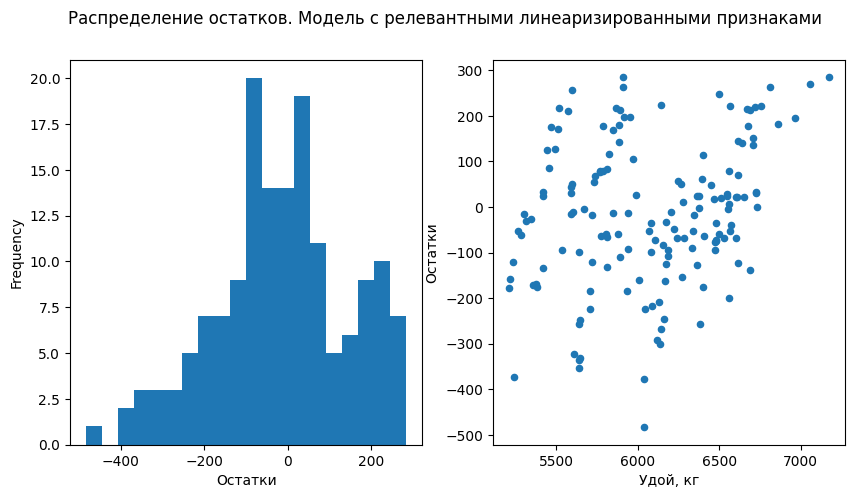

In [50]:
features = [
    "meal_value",
    "meal_value_squared",
    "meal_protein",
    "spo_type",
    "milk_fat_type",
    "age",
    "dad_breed",
    "pasture",
]
model_2 = fit_and_score(
    df_main,
    "milk_yield",
    features,
    LinearRegression,
    "Модель с релевантными линеаризированными признаками",
)

Значения всех метрик улучшились.

Гистограмма остатков по-прежнему смещено влево, т.е. модель имеет тенденцию переоценивать предсказываемые значения удоя.
Дисперсия распределения остатков стала более равномерной, но всё еще наблюдается тенденция недооценивать высокие удои.

<a class="ancor" id="23-bullet"></a>
### Модель с информацией об отцах коров

Добавим информацию об отцах коров

In [51]:
df_main = df_main.merge(df_dads, on="id", how="left")

Проверим, что для всех коров указаны отцы.

In [52]:
df_main["dad_name"].isna().sum()

np.int64(0)

Всё хорошо, пропусков нет.

Посмотрим как зависит медианный удой для коров с разными отцами.

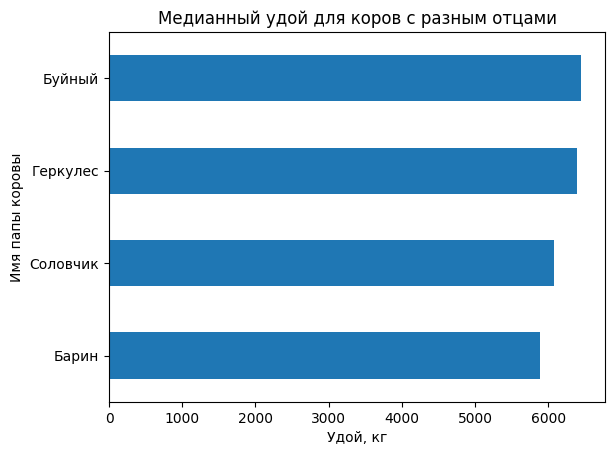

In [53]:
ax = (
    df_main.pivot_table(index="dad_name", values="milk_yield", aggfunc="median")
    .sort_values(by="milk_yield")
    .plot(
        kind="barh",
        legend=False,
        xlabel=translator["milk_yield"],
        ylabel=translator["dad_name"],
    )
)
_ = ax.set_title("Медианный удой для коров с разным отцами")

Видно, что для коров, у которых отцом являются Буйный или Геркулес, медианные удои выше.

R2_SCORE: 0.889
MAE: 122.654
MSE: 23247.915
RMSE: 152.473
MAPE: 0.020


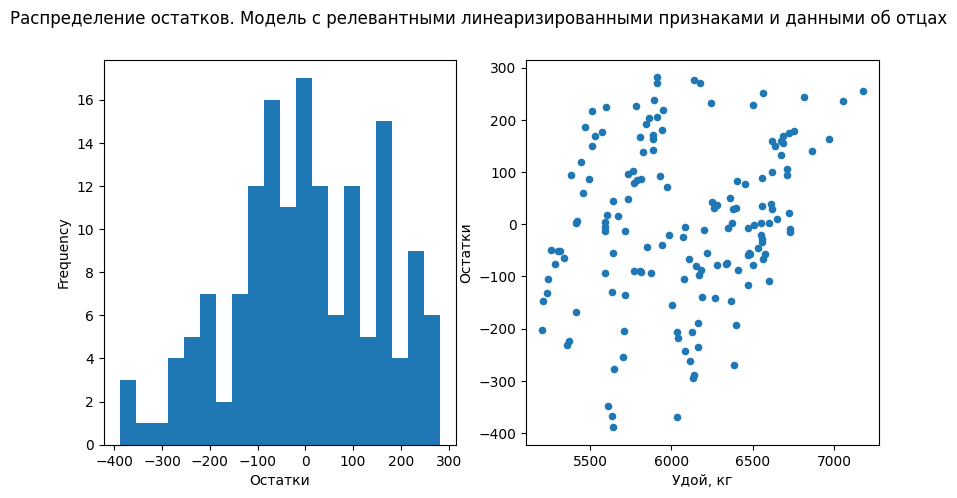

In [54]:
features = [
    "meal_value",
    "meal_value_squared",
    "meal_protein",
    "spo_type",
    "milk_fat_type",
    "age",
    "dad_breed",
    "pasture",
    "dad_name",
]
model_3 = fit_and_score(
    df_main,
    "milk_yield",
    features,
    LinearRegression,
    "Модель с релевантными линеаризированными признаками и данными об отцах",
)

Добавление информации об отцах несколько улучшило качество предсказаний (улучшились значения метрик, гистограмма распределения остатков стала ближе к нормальному распределению).

<a class="ancor" id="24-bullet"></a>
### Сравнение моделей
Давайте посмотрим сводную инфомрацию по получившимся моделям.

In [55]:
def compare_models(models: list[FitResult], sort_col: str = "") -> pd.DataFrame:
    if isinstance(models[0].model, LinearRegression):
        metrics = models[0].regr_metrics
    else:
        metrics = models[0].class_metrics
    return pd.DataFrame(
        [{fld: round(getattr(model, fld), 3) for fld in metrics} for model in models],
        index=[model.model_name for model in models],
    ).sort_values(by=sort_col, ascending=False)

In [56]:
models = [base_model, model_1, model_2, model_3]
compare_models(models, "r2_score")

,r2_score,mae,mse,rmse,mape
Модель с релевантными линеаризированными признаками и данными об отцах,0.889,122.654,23247.915,152.473,0.020
Модель с релевантными линеаризированными признаками,0.881,125.841,25068.576,158.331,0.021
Базовая модель,0.839,142.174,33945.659,184.243,0.024
Модель с релевантными признаками,0.836,143.337,34540.016,185.849,0.024


Наилучшие результаты показала модель с релевантными линеаризированными признаками и данными об отцах коров. $R^2$ для этой модели близко к 0.889. В целом же для всех моделей $R^2$ имеет значения от 0.84 до 0.89.

Распределение остатков наилучшей модели близко к нормальному с небольшим смещением в область отрицательных значений, что говорит о том, что модель в среднем переоценивает предсказываемые значения удоя. Однако, нужно отметить, что эта тенденция справедлива только для удоев менее примерно 6500 кг, при больших значениях модель имеет тенденцию недооценивать предсказываемые значения удоя.

Средняя абсолютная ошибка наилучшей модели составляет около 123 литров (примерно 2% предсказываемого значения).

Рассчитаем доверительные интервалы предсказаний наилучшей из наших моделей.

In [57]:
pd.Series(model_3.y_test - model_3.predicted).rename("Квантили").quantile(
    [0.05, 0.25, 0.5, 0.75, 0.95]
)

0.05   -264.780677
0.25    -89.616464
0.50     -4.789213
0.75    112.149134
0.95    236.471388
Name: Квантили, dtype: float64

Доверительный интервал по уровню 0.05-0.95 составляет от -265 до 236, что означает, что на тестовых данных в 90% случаем ошибка предсказания находится в этом диапазоне.

По уровню 0.25-0.75 доверительный интервал составляет от -90 до 112.

<a class="ancor" id="25-bullet"></a>
### Прогноз удоя коров, доступных для покупки

С данными о коровах для покупки есть существенная проблема, заключающаяся в отсутствии данных о корме коров.

По условию, недостающие признаки просто заполняются средними значениями из основного датафрейма, увеличенными на 5%.

In [58]:
df_buy_predict = df_buy.copy()
df_buy_predict["spo"] = df_main["spo"].mean() * 1.05
df_buy_predict["meal_protein"] = df_main["meal_protein"].mean() * 1.05
df_buy_predict["meal_value"] = df_main["meal_value"].mean() * 1.05

Добавим все необходимые категории

In [59]:
df_buy_predict["spo_type"] = df_buy_predict["spo"].transform(
    lambda x: "Высокое" if x > 0.9 else "Низкое"
)
df_buy_predict["milk_fat_type"] = df_buy_predict["milk_fat"].transform(
    lambda x: "Высокое" if x > 3.65 else "Низкое"
)
df_buy_predict["meal_value_squared"] = df_buy_predict["meal_value"].pow(2)

Посчитаем предсказанные значения и добавим их в таблицу с коровами, доступными для покупки

In [60]:
df_buy["predicted_milk_yield"] = model_3.predict(df_buy_predict).astype(int)
translator.update({"predicted_milk_yield": "Предсказанный удой, кг"})

Наша задача выбрать коров с удоем более 6000 кг в год. Давайте посмотрим, какие из коров, доступных для покупки, удовлетворяют этому критерию.

In [61]:
df_buy.query("predicted_milk_yield > 6000").rename(translator, axis=1)

,Порода,Тип пастбища,Порода папы коровы,Имя папы коровы,"Жирность молока, %","Белок молока, %",Возраст,"Предсказанный удой, кг"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6434
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6117
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6064
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6424
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6352
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6127
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6386
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6154
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6382
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6611


Предсказание явно можно улучшить. Можно, например, учесть, что, судя по имеющимся данным, коровы младше 2 лет не способны давайть удои выше ~ 5700 кг.

Создадим функцию, которая будет выдавать список коров, для которых удой будет превышать 6 000 кг с заданной вероятностью, посчитанной по распределению остатков.

In [62]:
def get_high_milk_yield_cows(prob: float, exclude_young: bool = True) -> pd.DataFrame:
    """
    Функция для получения коров с удоем молока более 6000 кг с заданной вероятностью.

    Параметры:
    ----------
    prob: Вероятность, с которой мы хотим получить коров с высоким удоем молока.
    """
    thr = pd.Series(model_3.y_test - model_3.predicted).quantile(1 - prob)
    if exclude_young:
        return df_buy.query(
            'predicted_milk_yield > (6000 - @thr) and age == "более_2_лет"'
        )
    return df_buy.query("predicted_milk_yield > (6000 - @thr)")

Например, список коров, которые с вероятность 95% будут давать удой более 6 000 кг в год.

In [63]:
get_high_milk_yield_cows(0.95).rename(translator, axis=1)

,Порода,Тип пастбища,Порода папы коровы,Имя папы коровы,"Жирность молока, %","Белок молока, %",Возраст,"Предсказанный удой, кг"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6434
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6424
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6352
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6386
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6382
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6611
10,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,6648
12,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,6424
13,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6382
15,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.34,3.069,более_2_лет,6386


Если мы при этом не хотим исключать коров младше 2 лет, то результат будет следующим.

In [64]:
get_high_milk_yield_cows(0.95, exclude_young=False).rename(translator, axis=1)

,Порода,Тип пастбища,Порода папы коровы,Имя папы коровы,"Жирность молока, %","Белок молока, %",Возраст,"Предсказанный удой, кг"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6434
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6424
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6352
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6386
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6382
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6611
10,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,6648
12,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,6424
13,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6382
14,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет,6341


<a class="ancor" id="26-bullet"></a>
### Выводы

Было обучено 4 модели линейной регрессии, предсказывающие величину удоя коров:
1. **Базовая модель** - использованы все имеющиеся признаки в исходном виде.
2. **Модель 1** - использованы только признаки статистически значимо влияющие на удой в исходном виде.
3. **Модель 2** - использованы признаки статистически значимо влияющие на удой в линеаризированном виде.
4. **Модель 3** - к признакам модели 2 добавлена информация об отцах коров.

Наилучшие результаты показала **модель 3** с релевантными линеаризированными признаками и данными об отцах коров. $R^2$ для этой модели близко к 0.889. В целом же для всех моделей $R^2$ имеет значения от 0.84 до 0.89.

Распределение остатков наилучшей модели близко к нормальному с небольшим смещением в область отрицательных значений, что говорит о том, что модель в среднем переоценивает предсказываемые значения удоя. Однако, нужно отметить, что эта тенденция справедлива только для удоев менее примерно 6500 кг, при больших значениях модель имеет тенденцию недооценивать предсказываемые значения удоя.

Средняя абсолютная ошибка наилучшей модели составляет около 123 литров (примерно 2% предсказываемого значения).

Доверительный интервал по уровню 0.05-0.95 составляет от -265 до 236, что означает, что на тестовых данных в 90% случаем ошибка предсказания находится в этом диапазоне.

На основе модели 3 создана функция, позволяющая предсказывать удои коров и выбирать тех из них, кто даст удои более 6 000 кг в год с заданной вероятностью (посчитанной по распределению остатков).

[Оглавление](#0-bullet)

<a class="ancor" id="27-bullet"></a>
## 6. Обучение модели логистической регрессии

<a class="ancor" id="27-bullet"></a>
### Базовая модель
Для базовой модели будем использовать все доступные исходно признаки в исходном же (нелинеаризированном) виде.

Значение удоя исключим, так как нам оно неизвестно для доступных к покупке коров.

Accuracy: 0.555
Precision: 0.591
Recall: 0.756


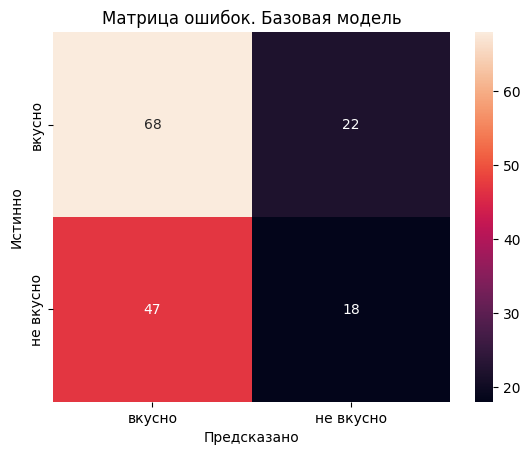

In [65]:
target = "milk_taste"
features = list(
    df_main.columns.difference(
        [
            target,
            "id",
            "spo_type",
            "milk_fat_type",
            "meal_value_squared",
            "milk_yield",
        ]
    )
)

base_log_model = fit_and_score(
    df_main, target, features, LogisticRegression, "Базовая модель", "вкусно"
)

Модель не очень хорошо справляется со своей задачей. Точность (accuracy) всего около 55%, т.е. правильно предсказывается только в половине случаев.

<a class="ancor" id="28-bullet"></a>
### Продвинутая модель
Попробуем использовать только статистически значимые признаки.

Accuracy: 0.619
Precision: 0.640
Recall: 0.789


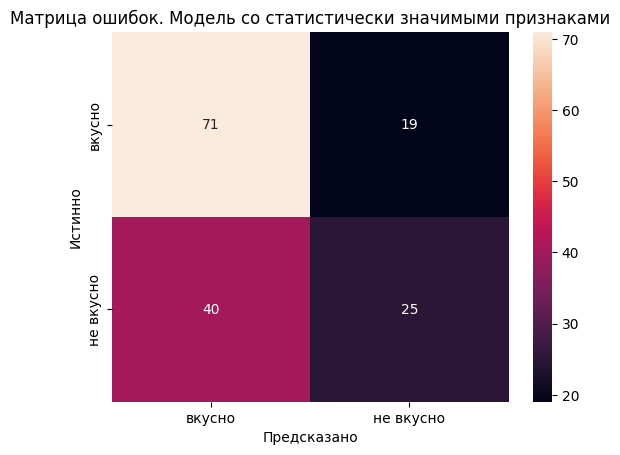

In [66]:
features = [
    "meal_value",
    "meal_protein",
    "spo",
    "milk_fat",
    "milk_protein",
    "pasture",
    "age",
]
advanced_model = fit_and_score(
    df_main,
    target,
    features,
    LogisticRegression,
    "Модель со статистически значимыми признаками",
    "вкусно",
)

Значения метрик подросли. Давайте сравним эти две модели между собой.

<a class="ancor" id="29-bullet"></a>
### Сравнение моделей

In [67]:
log_models = [base_log_model, advanced_model]
compare_models(log_models, "accuracy")

,accuracy,precision,recall
Модель со статистически значимыми признаками,0.619,0.640,0.789
Базовая модель,0.555,0.591,0.756


Как видно из данных, значения метрик для модели, использующей только признаки статистически значимо влияющие на наш таргет, несколько лучше, поэтому будем использовать эту модель.

Accuracy модели составляет 0.619, что говорит о том, что на тестовых данных модель в среднем правильно предсказывает вкус молока примерно в 62% случаев.

Precision модели составляет 0.64, т.е. на тестовых данных среди коров, помеченных моделью, как дающих вкусное молоко, действительно только около 64% дают вкусное молоко.

Recall модели составляет 0.789, т.е. на тестовых данных нашей модели удалось верно распознать около 79% коров действительно дающих вкусное молоко.

По заданию нашему фермеру очень важно, чтобы купленные им коровы давайли действительно вкусное молоко, т.е. нужно минимизировать ошибки первого рода или, что эквивалентно, максимизировать метрику precision.

Но для начала давайте посмотрим как значения метрик зависят от порога классификации.

<a class="ancor" id="30-bullet"></a>
### Предсказание вкусного молока

Напишем пару вспомогательных функций.

In [68]:
def predict_with_thr(
    model: LogisticRegression, X: pd.DataFrame, thr: float
) -> pd.Series:
    """
    Функция для предсказания вероятности "вкусно" c заданным порогом.

    Параметры:
    ----------
    - model: Обученная модель логистической регрессии.
    - X: DataFrame с признаками для предсказания.
    - thr: Порог вероятности для классификации "вкусно".
    """

    tasty_probs = model.predict_proba(X)[:, 0]  # type: ignore
    return pd.Series(tasty_probs).transform(
        lambda x: "вкусно" if x > thr else "не вкусно"
    )


def calc_metrics(fit_result: FitResult, metric_func: Callable, thr: float) -> float:
    """
    Функция для вычисления метрики модели классификации.

    Параметры:
    ----------
    - fit_result: Результат обучения модели, содержащий предсказания и тестовые данные.
    - metric_func: Функция метрики, которую нужно вычислить (например, precision_score).
    - thr: Порог вероятности для классификации "вкусно".
    """

    predictions = predict_with_thr(fit_result.model, fit_result.X_test, thr)  # type: ignore
    try:
        return metric_func(fit_result.y_test, predictions, pos_label="вкусно", zero_division=np.nan)  # type: ignore
    except TypeError:
        return metric_func(fit_result.y_test, predictions)

Построим графики значения метрик для разных порогов классификации.

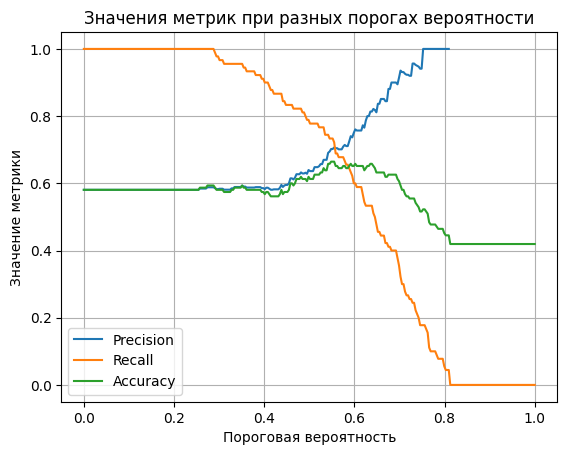

In [69]:
xvals = np.linspace(0, 1, 300)

precision = pd.Series(
    np.vectorize(partial(calc_metrics, advanced_model, precision_score))(xvals)
)
recall = pd.Series(
    np.vectorize(partial(calc_metrics, advanced_model, recall_score))(xvals)
)
accuracy = pd.Series(
    np.vectorize(partial(calc_metrics, advanced_model, accuracy_score))(xvals)
)

plt.plot(xvals, precision, label="Precision")
plt.plot(xvals, recall, label="Recall")
plt.plot(xvals, accuracy, label="Accuracy")
plt.xlabel("Пороговая вероятность")
plt.ylabel("Значение метрики")
plt.grid(visible=True)
plt.legend()
_ = plt.title("Значения метрик при разных порогах вероятности")

Из графиков видно, что accuracy нашей моедли максимально при порогах классификации примерно в диапазоне от 0.55 до 0.65.

Precision растёт в диапазоне порогов классификации примерно от 0.45 до 0.75.

Recall же падает при порогах классификации от примерно 0.3 до 0.8.

Напишем функцию для вычисления порога, при котором достигается интересующее нас значение метрики.

In [70]:
def find_thr(
    fit_result: FitResult,
    metric_func: Callable,
    score: float,
    step_dir: Literal[1, -1] = 1,
) -> float:
    """
    Функция для нахождения порога классификации, при котором значение метрики достигает заданного уровня.

    Параметры:
    ----------
    - fit_result: Результат обучения модели, содержащий предсказания и тестовые данные.
    - metric_func: Функция метрики, которую нужно вычислить (например, precision_score).
    - score: Значение метрики, которое мы хотим достичь.
    - step_dir: Направление шага для поиска порога классификации (1 для увеличения, -1 для уменьшения).
    """
    n_steps = 100
    space = np.linspace(0, 1, n_steps)
    i = 0 if step_dir > 0 else -1
    for _ in range(n_steps):
        if score <= calc_metrics(fit_result, metric_func, space[i]):  # type: ignore
            return float(space[i])
        i += step_dir
    return math.inf

С использованием этой функции можно найти значение при котором precision достигает единицы, т.е. на тестовых данных ошибки первого рода устранены и всё молоко помеченное как вкусное действительно является вкусным.

In [71]:
ideal_prec_thr = find_thr(advanced_model, precision_score, 1.0)
ideal_prec_thr

0.7575757575757577

Значение recall при этом будет довольно низким...

In [72]:
calc_metrics(advanced_model, recall_score, ideal_prec_thr)

0.17777777777777778

Напишем еще одну функцию для добавления колонки с предсказанием вкуса молока с заданным значением метрики precision.

In [73]:
def get_tasty_milk_cows(df: pd.DataFrame, precision: float) -> pd.DataFrame:

    thr = find_thr(advanced_model, precision_score, precision)
    return df.assign(
        predicted_milk_taste=predict_with_thr(
            advanced_model.model, advanced_model.transform(df_buy_predict), thr  # type: ignore
        )
    )

# Не забываем обновить наш словарик с переводами признаков
translator.update({"predicted_milk_taste": "Предсказанный вкус молока"})

Посмотрим, что получится, если предсказать вкус молока с precision равным единице.

In [74]:
get_tasty_milk_cows(df_buy, 1.0).rename(translator, axis=1)

,Порода,Тип пастбища,Порода папы коровы,Имя папы коровы,"Жирность молока, %","Белок молока, %",Возраст,"Предсказанный удой, кг",Предсказанный вкус молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6434,вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6117,вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6064,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6424,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6352,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6127,не вкусно
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6386,не вкусно
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6154,вкусно
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6382,не вкусно
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6611,не вкусно


<a class="ancor" id="31-bullet"></a>
### Выводы

Обучено 2 модели логистической регрессии для предсказания вкуса молока:
* **Базовая модель** - использует все доступные исходно признаки для предсказания.
* **Продвинутая модель** - использует только статистически значимые признаки для предсказания.

Метрики показывают, продвинутая модель на тестовых данных лучше справляется с поставленной задачей. При использовании порога классификации по умолчанию получились следующие значения:
* Accuracy модели составляет 0.619, что говорит о том, что на тестовых данных модель в среднем правильно предсказывает вкус молока примерно в 62% случаев.
* Precision модели составляет 0.64, т.е. на тестовых данных среди коров, помеченных моделью, как дающих вкусное молоко, действительно только около 64% дают вкусное молоко.
* Recall модели составляет 0.789, т.е. на тестовых данных нашей модели удалось верно распознать около 79% коров действительно дающих вкусное молоко.

Изучение зависимости значений метрик качества от порога классификации дало следующие результаты для продвинутой модели:
* accuracy максимально (около 0.65) при порогах классификации в диапазоне от 0.55 до 0.65.
* Precision растёт с ~0.58 до 1. в диапазоне порогов классификации примерно от 0.45 до 0.75.
* Recall же падает с единицы до нуля при порогах классификации от примерно 0.3 до 0.8.

На основе продвинутой модели написана функция, добавляющая в датафрейм с доступными для покупки коровами предсказание вкуса молока с заданным значением метрики precision.

<a class="ancor" id="32-bullet"></a>
## 7. Итоговое предсказание

Напишем финальную функцию, позволяющую получать список коров для покупки с возможностью задавать как вероятность получения годового удоя, превышающего 6000 кг, так и значение метрики precision в предсказании вкуса молока. 

In [75]:
def get_cows_to_buy(
    high_yield_prob: float, tasty_milk_prec: float, exclude_young: bool = True
) -> pd.DataFrame:

    high_yield_cows = get_high_milk_yield_cows(high_yield_prob, exclude_young)
    return (
        get_tasty_milk_cows(high_yield_cows, tasty_milk_prec)
        .query('predicted_milk_taste == "вкусно"')
        .rename(translator, axis=1)
    )

Можно попробовать получить список интересующих нас коров с жесткими критериями:
* Вероятность получения удоя, превышающего 6000 кг в год 80%
* Precision для предсказания вкусного молока 1.

In [76]:
get_cows_to_buy(0.8, 1.)

,Порода,Тип пастбища,Порода папы коровы,Имя папы коровы,"Жирность молока, %","Белок молока, %",Возраст,"Предсказанный удой, кг",Предсказанный вкус молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6434,вкусно
13,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6382,вкусно


Под такие критерии подходит всего 2 коровы.

Нужно помнить, что наши функция нахождения коров с нужным удоем принудительно отсеивает коров моложе 2 лет, так как они не способны дать удой выше 6 000 кг в год.

Можно, однако, отключить эту опцию.

In [77]:
get_cows_to_buy(0.8, 1., exclude_young=False)

,Порода,Тип пастбища,Порода папы коровы,Имя папы коровы,"Жирность молока, %","Белок молока, %",Возраст,"Предсказанный удой, кг",Предсказанный вкус молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6434,вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6117,вкусно
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6154,вкусно
13,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6382,вкусно


Альтернативно можно понизить требование к recision, скажем, до 0.7.

In [78]:
get_cows_to_buy(0.8, 0.7)

,Порода,Тип пастбища,Порода папы коровы,Имя папы коровы,"Жирность молока, %","Белок молока, %",Возраст,"Предсказанный удой, кг",Предсказанный вкус молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6434,вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6352,вкусно
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6386,вкусно
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6611,вкусно
12,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,6424,вкусно
13,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6382,вкусно
15,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.34,3.069,более_2_лет,6386,вкусно


Но финальное решение, разумеется, на усмотрение нашего фермера, а `get_cows_to_buy` - удобный интерфейс, который поможет ему принять это решение!

[Оглавление](#0-bullet)

<a class="ancor" id="33-bullet"></a>
## Итоговые выводы

1. **Загрузка данных**
    Все данные загружены в 3 датафрейма:
    * `df_main` - Основная инфомрация о коровах, уже имеющихся на ферме
    * `df_dads` - Информация об отцах коров, имеющихся на ферме
    * `df_buy` - Информация о коровах, которых можно приобрести

    Названия колонок данных приведены к каноничному виду и создан словарь для отображения этих названий в понятные русскоязычные аналоги.

    Возможно имеются некоторые проблемы с данными (как минимум, с удоем).
2. **Предобработка данных**
   * Пропуски данных не обнаружены
   * Удалены явные дубликаты
   * Удалены неявные дубилкаты в столбцах породы отца и типа пастбища
   * Унифицированы значения столбца типа пастбища
   * Удалена запись с аномальным значением удоя (45 616)
3. **Исследовательский анализ данных**
    Выявлены следующие особенности данных:
   1. Коровы, имеющиеся на ферме:
      * Данные удоя, ЭКЕ и белка молока имеют близкие среднее и медианное значения, а также близкое к нормальному распределения.
      * Для всех данных СО значительно меньше средних значений, разброс данных не особо велик.
      * Сами данные имеют очень разные масштабы своих абсолютных значений.
      * В СПО просматривается разделение значений на 3 группы, возможно это связано с каким-то из категориальных признаков.
      * В жирности молока общая гистограмма тоже похожа на сумму двух гистограмм, что опять же может быть связано с влиянием одного из категориальных призанков. Изучим это далее.
      * Для значений белка в молоке боксплот говорит о наличии небольшого количества выбросов, которые были удалены.
      * Категориальные данные распределены более-менее равномерно для всех признаков за исключением возраста коров: коров моложе 2 лет значительно меньше, чем коров постарше.
      * Среди отцов коров выделяются 2 лидера: "Барин" и "Буйный" и два аутсайдера: "Соловчик" и "Геркулес".

   2. Коровы, доступные для покупки:
      Коров для покупки в целом довольно мало, говорить о распределениях их параметров довольно сложно, но можно подметить общие тенденции:
      * СО значительно меньше центральных значений, поэтому разброс данных не особо велик.
      * Несколько отличается распределение отцов предлагаемых коров, здесь уже "Геркус" среди лидеров, а "Барин" в аутсайдерах.
      * В остальном распределения категориальных признаков похожи на распределения признаков для уже имеющихся на ферме коров.
4. **Статистический анализ данных**
    1. Корреляционный показал следующие результаты:
       * Самая сильная корреляция (1.0) наблиюдается между **удоем** и **возрастом**
      * Сильные (>0.75) корреляции наблюдается между:
        * **возрастом** и **ЭКЕ**
        * **возрастом** и **СПО**
      * Средняие (>0.5) корреляция наблюдается между:
        * **ЭКЕ** и **жирностью молока**
        * **удоем** и **ЭКЕ**
        * **удоем** и **жирностью молока**
        * **жирностью молока** и **возрастом**
        * **удоем** и **СПО**
        * **СПО** и **жирностью молока**
        * **ЭКЕ** и **СПО**
        * **СПО** и **вкусом** молока
        * **удоем** и **породой отца**
   1. Анализ диаграмм рассеяния позволил выявить следующие закономерности:
      1. Присутствует довольно сильная **близкая к линейной** корреляция между **удоем** и **энергетической кормовой единицей**.
      2. Между **протеином в корме** и **удоем** прослеживается довольно **слабая линейная зависимость**.
      3. Между **СПО** и **удоем** **линейной зависимости не прослеживается**, однако данные явно кластеризуются в 2 большие группы: Для СПО более 0.9 Удои составляют более 6000 кг, а для меньших СПО удои не превышают 6000 кг. Похоже, что СПО можно использовать как отсекающий фактор, так как по постановке задачи нам нужны коровы, способные давать более 6000 кг молока в год, поэтому не стоит рассматривать для покупки коров, у которых СПО менее 0.9.
      В датафрейм добавлен категориальный признак `spo_type`, имеющий значение `Высокое` для значений СПО, превышающих 0.9, и `Низкое` в остальных случаях.
      4. Между **жирностью молока** и **удоем** тоже **не прослеживается линейной зависимости**. Но можно выделить 2 кластера данных, в которых сосредоточено большинство данных. Жирность имеет два характерных значения: одно около 3.6%, а второе около 3.75% (а также равномерный хвост в сторону более низких значений, но таких коров не очень много), при этом для первого значения жирности удои составляют от 5300 до 6500 кг в год, а для второго от 6000 до 7250 кг. В датафрейм добавлен категориальный признак, принимающий значение `Высокое` при превышение жирностью значения 3.65%, и `Низкое` во всех остальных.
      5. Между содержанием **белка в молоке** и **удоем** **не прослеживается никакой взаимосвязи**.
      6. Коровы возрастом до 2 лет дают удои до примерно 5600 кг, а возрастом более 2 лет от этого значения. Поэтому возраст менее 2 лет можно использовать как отсекающий параметр, нас точно не интересуют такие коровы, так как они не способны дать более 6000 кг молока в год.
      7. Коровы возрастом менее двух лет также дают молоко с СПО, не превышающим 0.9, тогда как для коровы постарше дают молоко с любым содержанием СПО.
   2. Проверка статистических гипотез о влиянии категориальных признаков на **удой** дал следующие результаты:
      1. Данные **не** позволяют отвергнуть гипотезу об **отсутствии** влияния **породы коров** на величину удоя.
      2. Данные **позволяют** отвергнуть гипотезу об **отсутствии** влияния **типа пастбища** на величину удоя.
      3. Данные **позволяют** отвергнуть гипотезу об **отсутствии** влияния **породы отца коровы** на величину удоя.
      4. Данные **позволяют** отвергнуть гипотезу об **отсутствии** влияния **вкуса молока** на величину удоя.
   3. Проверка статистических гипотез о влиянии признаков на **вкус молока** дал следующие результаты:
      1. Данные **позволяют** отвергнуть гипотезу о равенстве положения распределений каждого из численных призанков (удой, ЭКЕ, протеин в корме, СПО, жирность и белок молока) для вкусного и не вкусного молока.
      2. Данные **не** позволяют гипотезу о равенстве частот значений **породы коровы** и **породы отца коровы** для вкусного и невкусного молока.
      3. Данные **позволяют** гипотезу о равенстве частот значений **типа пастбища**, **возраста**, **типа СПО** и **типа жирности молока** для вкусного и невкусного молока.
5. **Обучение моделей линейной регрессии для предсказания удоев**
    Было обучено 4 модели линейной регрессии, предсказывающие величину удоя коров:
    1. **Базовая модель** - использованы все имеющиеся признаки в исходном виде.
    2. **Модель 1** - использованы только признаки статистически значимо влияющие на удой в исходном виде.
    3. **Модель 2** - использованы признаки статистически значимо влияющие на удой в линеаризированном виде.
    4. **Модель 3** - к признакам модели 2 добавлена информация об отцах коров.

    Наилучшие результаты показала **модель 3** с релевантными линеаризированными признаками и данными об отцах коров. $R^2$ для этой модели близко к 0.889. В целом же для всех моделей $R^2$ имеет значения от 0.84 до 0.89.

    Распределение остатков наилучшей модели близко к нормальному с небольшим смещением в область отрицательных значений, что говорит о том, что модель в среднем переоценивает предсказываемые значения удоя. Однако, нужно отметить, что эта тенденция справедлива только для удоев менее примерно 6500 кг, при больших значениях модель имеет тенденцию недооценивать предсказываемые значения удоя.

    Средняя абсолютная ошибка наилучшей модели составляет около 123 литров (примерно 2% предсказываемого значения).

    Доверительный интервал по уровню 0.05-0.95 составляет от -265 до 236, что означает, что на тестовых данных в 90% случаем ошибка предсказания находится в этом диапазоне.

    На основе модели 3 создана функция, позволяющая предсказывать удои коров и выбирать тех из них, кто даст удои более 6 000 кг в год с заданной вероятностью (посчитанной по распределению остатков).
6. **Обучение моделей логистической регрессии для предсказания вкуса молока**
    Обучено 2 модели логистической регрессии для предсказания вкуса молока:
    * **Базовая модель** - использует все доступные исходно признаки для предсказания.
    * **Продвинутая модель** - использует только статистически значимые признаки для предсказания.

    Метрики показывают, продвинутая модель на тестовых данных лучше справляется с поставленной задачей. При использовании порога классификации по умолчанию получились следующие значения:
    * Accuracy модели составляет 0.619, что говорит о том, что на тестовых данных модель в среднем правильно предсказывает вкус молока примерно в 62% случаев.
    * Precision модели составляет 0.64, т.е. на тестовых данных среди коров, помеченных моделью, как дающих вкусное молоко, действительно только около 64% дают вкусное молоко.
    * Recall модели составляет 0.789, т.е. на тестовых данных нашей модели удалось верно распознать около 79% коров действительно дающих вкусное молоко.

    Изучение зависимости значений метрик качества от порога классификации дало следующие результаты для продвинутой модели:
    * accuracy максимально (около 0.65) при порогах классификации в диапазоне от 0.55 до 0.65.
    * Precision растёт с ~0.58 до 1. в диапазоне порогов классификации примерно от 0.45 до 0.75.
    * Recall же падает с единицы до нуля при порогах классификации от примерно 0.3 до 0.8.

    На основе продвинутой модели написана функция, добавляющая в датафрейм с доступными для покупки коровами предсказание вкуса молока с заданным значением метрики precision.
7. **Выводы о моделях линейной и логистической регрессии**
   1. Для улучшения качества модели линейной регрессии было использовано:
        * Использование только статистически значимых признаков
        * Линеаризация признаков
        * Преобразование численных признаков в категориальные
   2. Для улучшения качества модели логистической регрессии было использовано:
        * Использование только статистически значимых признаков
   3. Возможности для дальнейшего улучшения качества моделей:
        * добавление дополнительных релевантных признаков на основе комбинаций уже имеющихся признаков
        * добавление дополнительных признаков, не основанных на уже имеющихся
   4. В работе был использван ряд важных метрик.
      1. Линейная регрессия:
         1. $R^2$ - показывает в скольки процентах случаев наша модель делает предсказание лучше, чем просто среднее значение.
         2. Mean absolute error (mea) - средняя абсолютная ошибка показывает среднюю величину абсолютной ошибки пресказаний модели. Меньше подвержена влияюнию выбросов, чем близкая по смыслу метрика RMSE.
         3. Mean Absolute Percent Error (rmse) - среднее значение абсолютной ошибки, выраженное в процентах. Даёт представление о том на сколько в относительных единицах ошибается наша модель.
         4. Mean Sqaured Error (mse) - среднеквадратичная ошибка. Среднее значение квадрата отклонения предсказания от истинного значения. На основе минимизации этой величины работает модель линейной регрессии, относительно неудобна для восприятия.
         5. Root Mean Squared Error (rmse) - квадратный корень из среднеквадратичной ошибки показывает среднюю ошибку модели в абсолютных единицах. Квадратный корень из метрики mse
      2. Логистическая регрессия:
         1. Accuracy - показывает в какой доле случаев наша модель даёт верное предсказание. Само по себе высокое значение accuracy - не гарантия того, что наша модель работает хорошо. Например, если предсказываемое событие достаточно редкое, то модель, которая будет предсказывать, что интересующее нас событие никогда не происходит будет иметь высокое значение accuracy
         2. Precision - показывает в какой доле случаев предсказанной событие действительно является таковым. Напрямую связано с ошибками первого рода. Чем выше precision - тем ниже ошибка первого рода.
         3. Recall - показывает какую долю от интересующих нас событий модель способна предсказать. Напрямую связана с ошибками второго рода. Чем выше recall - тем ниже ошибка второго рода.